In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Table of Contents

# I. **[Introduction](#Introduction)**

1. [Importing and Cleaning Data](#ID)
2. [Data Exploration](#DE)

  a.   [Rating Data](#ratingdata)

  b.   [User Data](#userdata)

  c.   [Movie Data](#moviedata)

  d.   [Overview](#overview)

#II.**[Preprocessing](#Preprocessing)**

# III. **[Methods](#Methods)**
1.   [Autorec: Autoencoders meet collaborative filtering](#Autorec)
2.   [Training deep autoencoders for collaborative filtering](#DECF)
3.   [Collaborative denoising auto-encoders for top-n recommender systems](#CDE)
  
  a. [Adding Gaussian to AutoRec](#GAR)

  b. [Adding Gaussian to Deep Autoencoder](#DAE)

  c. [Adding Dropout Noise](#DN)

# IV. **[Results and Discussions](#ResultsDiscussions)**
# V. **[References](#References)**


<a name="Introduction"></a>
# Introduction

Collaborative filtering recommendation methods assume that people who have agreed in the past will agree in the future. A company can recommend items to a target user based on the interests of similar users. Similar users in this context refers to users who have nearly the same rating patterns as a target user. I chose to do this project to gain a better understanding of how these valuable algorithms work. The objective of the project is to determine the movie ratings a user would give to movies he/she has not seen. If a company is able to suggest content that users are interested in then it becomes more likely that the user will buy products or consume more content. Some examples of recommender systems are product recommendations on Amazon, Netflix suggestions for movies and TV shows in your feed, recommended videos on YouTube, music on Spotify, the Facebook newsfeed and Google Ads. Recommender systems are really critical in some industries as they can generate a huge amount of income or also be a way to stand out significantly from competitors. 



<a name="ID"></a>
###Importing and Cleaning Data [1]

In [ ]:
!pip install --upgrade tensorflow
from datetime import datetime
from IPython.display import Markdown
from os.path import join
from os.path import exists
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.layers import Input, Dense, Embedding, Flatten, Dropout, merge, Activation, BatchNormalization, LeakyReLU
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras import initializers
from tensorflow.python.keras.layers import add, concatenate
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow.python.keras.models import model_from_json
from sklearn import preprocessing
from keras.utils import plot_model



Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.4.1)


In [ ]:
#Load data to dataframe
df_rating = pd.read_csv('/content/drive/MyDrive/movielens /ml-1m/ratings.dat', sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'])
df_user = pd.read_csv('/content/drive/MyDrive/movielens /ml-1m/users.dat', sep='::', header=None, names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])
df_movie = pd.read_csv('/content/drive/MyDrive/movielens /ml-1m/movies.dat', sep='::', header=None, names=['movie_id', 'title', 'genre'])

In [ ]:
#age group dictionary
age_group_dict = {
    1:  "Under 18",
    18:  "18-24",
    25:  "25-34",
    35:  "35-44",
    45:  "45-49",
    50:  "50-55",
    56:  "56+"
}

In [ ]:
# occupation dictionary
occupation_dict = {
    0:  "other or not specified",
    1:  "academic/educator",
    2:  "artist",
    3:  "clerical/admin",
    4:  "college/grad student",
    5:  "customer service",
    6:  "doctor/health care",
    7:  "executive/managerial",
    8:  "farmer",
    9:  "homemaker",
    10:  "K-12 student",
    11:  "lawyer",
    12:  "programmer",
    13:  "retired",
    14:  "sales/marketing",
    15:  "scientist",
    16:  "self-employed",
    17:  "technician/engineer",
    18:  "tradesman/craftsman",
    19:  "unemployed",
    20:  "writer"
}

<a name="DE"></a>
###Data Exploration

<a name="ratingdata"></a>
###Rating Data

In [ ]:
df_rating['timestamp'] = df_rating['timestamp'].apply(datetime.fromtimestamp)
df_rating['year'] = df_rating['timestamp'].dt.year
df_rating['month'] = df_rating['timestamp'].dt.month
df_rating = df_rating.sort_values('timestamp')
print('First 5:')
display(df_rating.head())
print()
print('Last 5:')
display(df_rating.tail())

First 5:


user_id  movie_id  rating           timestamp  year  month
1000138     6040       858       4 2000-04-25 23:05:32  2000      4
1000153     6040      2384       4 2000-04-25 23:05:54  2000      4
999873      6040       593       5 2000-04-25 23:05:54  2000      4
1000007     6040      1961       4 2000-04-25 23:06:17  2000      4
1000192     6040      2019       5 2000-04-25 23:06:17  2000      4


Last 5:


user_id  movie_id  rating           timestamp  year  month
825793     4958      2399       1 2003-02-28 17:45:38  2003      2
825438     4958      1407       5 2003-02-28 17:47:23  2003      2
825724     4958      3264       4 2003-02-28 17:49:08  2003      2
825731     4958      2634       3 2003-02-28 17:49:08  2003      2
825603     4958      1924       4 2003-02-28 17:49:50  2003      2

In [ ]:
print('Years:', df_rating.year.unique())
print('Months', df_rating.month.unique())
print('#Unique users:', df_rating.user_id.nunique())
print('#Unique movies:', df_rating.movie_id.nunique())
print('Unique ratings:', df_rating.rating.unique())
print('Average rating:', round(df_rating.rating.mean(), 2))
print('Frequency of each rating value:')
print(df_rating['rating'].value_counts())

Years: [2000 2001 2002 2003]
Months [ 4  5  6  7  8  9 10 11 12  1  2  3]
#Unique users: 6040
#Unique movies: 3706
Unique ratings: [4 5 3 2 1]
Average rating: 3.58
Frequency of each rating value:
4    348971
3    261197
5    226310
2    107557
1     56174
Name: rating, dtype: int64


We can see that the data is from 2000 to 2003.
There are 6040 unique users rating 3706 movies.
The rating values are ranging from 1 to 5. The average rating is around 3.6 and most frequent rating value is 4.

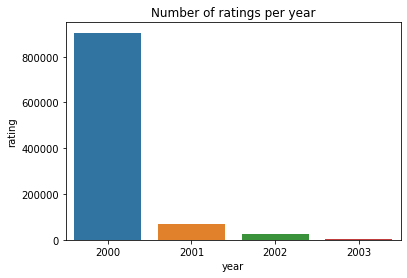

In [ ]:
rating_counts = (
    df_rating[['year', 'rating']]
    .groupby(['year'])
    .count()
    .reset_index()
)
ax = sns.barplot(x='year', y = 'rating', data=rating_counts)
ax.set_title('Number of ratings per year')
plt.show()

You can observe that the most number of ratings are during the year 2000, approximately 90%.  

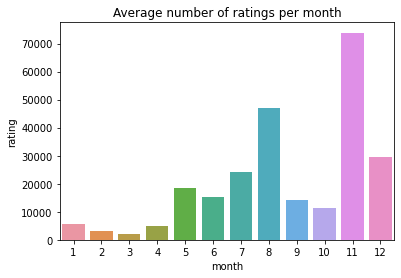

In [ ]:
avrg_rating = (
    df_rating[['month', 'rating']]
    .groupby(['month'])
    .count()
    .reset_index()
)
avrg_rating['rating'] = avrg_rating['rating'] / 4
ax = sns.barplot(x='month', y = 'rating', data=avrg_rating)
ax.set_title('Average number of ratings per month')
plt.show()

November has the highest average number of ratings followed by August and December.

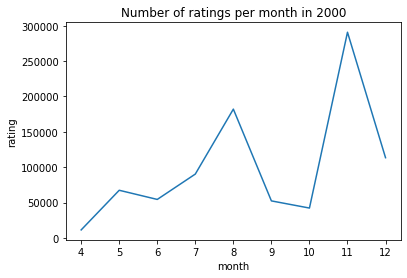

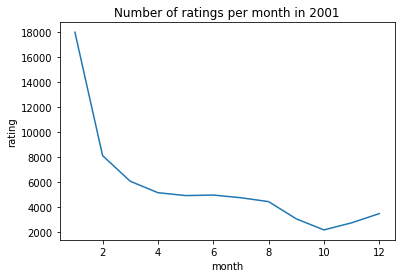

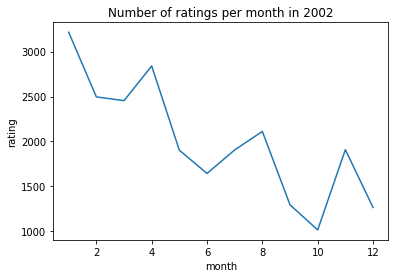

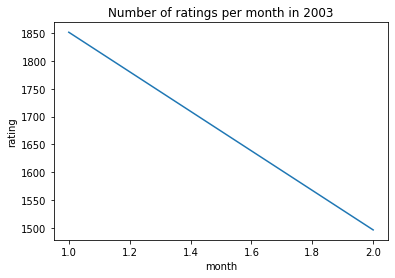

In [ ]:
rating_month = (
    df_rating[['year', 'month', 'rating']]
    .groupby(['year', 'month'])
    .count()
    .reset_index()
)
# print(rating_month)
for year in rating_month['year'].unique():
    rate_month= rating_month.loc[rating_month['year'] == year]
    # print(rate_month)
    sns.lineplot('month', 'rating', data=rate_month).set_title('Number of ratings per month in %s' %year)
    plt.show()

In 2000, the highest number of ratings are in November and around 90% of ratings are from this year. In 2001 and 2002, the number of ratings dissipated and we only have 2 months of data for 2003.

Distribution of Ratings

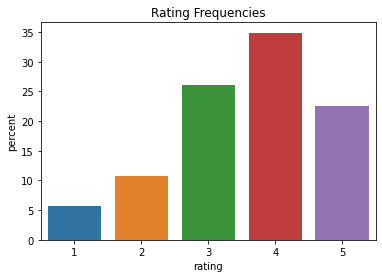

In [ ]:
norm_counts = (
    df_rating['rating']
    .value_counts(normalize=True, sort=False)
    .multiply(100)
    .reset_index()
    .rename(columns={'rating': 'percent', 'index': 'rating'})
)
ax = sns.barplot(x='rating', y='percent', data=norm_counts)
ax.set_title('Rating Frequencies')
plt.show()

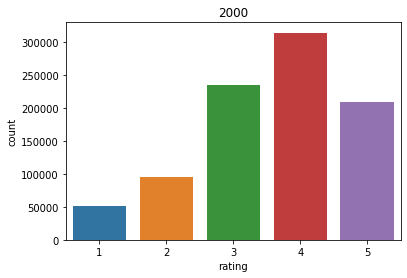

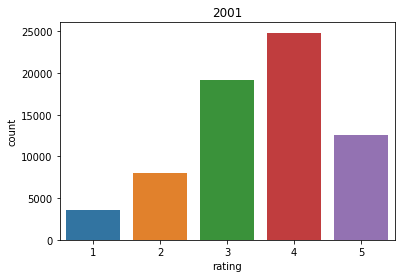

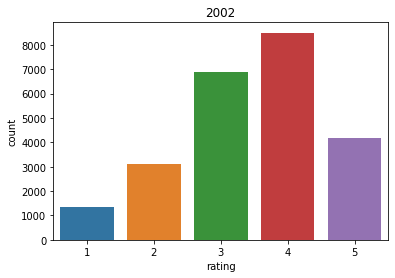

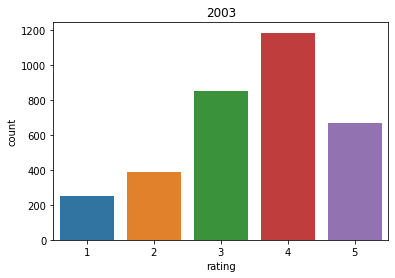

In [ ]:
rating_year= (df_rating[['rating', 'year']]
              .value_counts()
              .reset_index())

for year in rating_year['year'].unique():
  # print(year)
  rate_year= rating_year.loc[rating_year['year'] == year]
  df = pd.DataFrame(rate_year)
  df.rename(columns={0: 'count'}, inplace = True)
  # print (rate_year)
  sns.barplot(x="rating",y = 'count', data = rate_year).set_title('%s' %year)
  plt.show()


Throughout the years, the average rating has always been 4. Approximately 35% of rating are 4 and 26% and 21% foor 3 and 5.

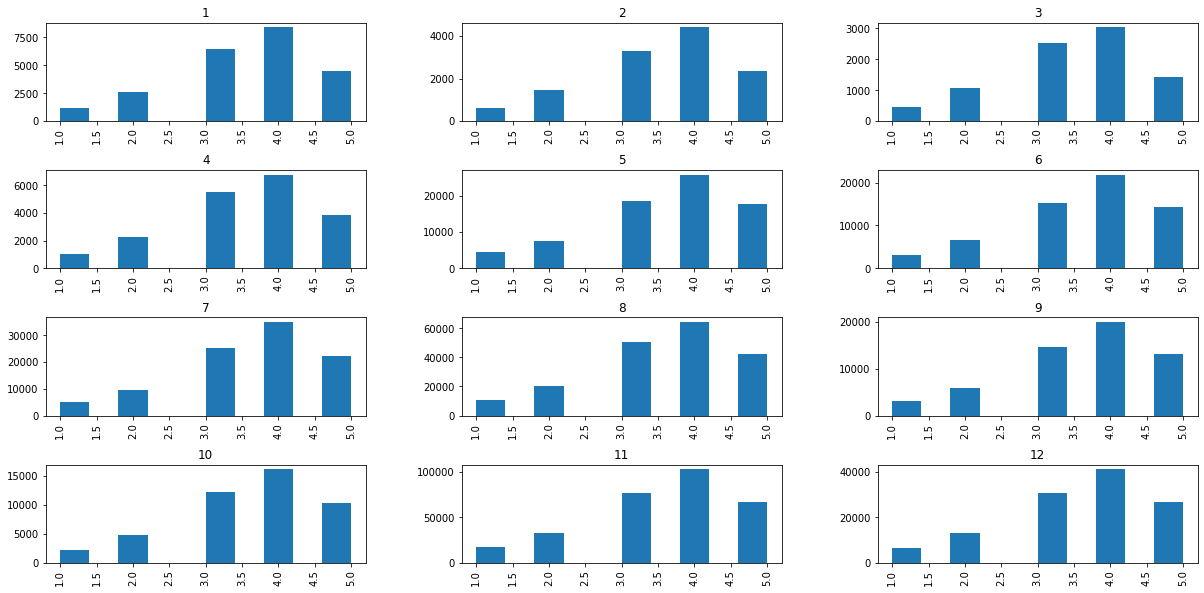

In [ ]:
df_rating['rating'].hist(by=df_rating['month'], figsize=(20, 10));

Through similar distribution in the overall and yearly graphs, we can observe that the overall rating average is approximately 3.6.

year month  # of Ratings
Date                                
2000-04-01  2000     4         11396
2000-05-01  2000     5         67437
2000-06-01  2000     6         54486
2000-07-01  2000     7         90334
2000-08-01  2000     8        182109
2000-09-01  2000     9         52421
2000-10-01  2000    10         42294
2000-11-01  2000    11        290793
2000-12-01  2000    12        113487
2001-01-01  2001     1         18004
2001-02-01  2001     2          8136
2001-03-01  2001     3          6083
2001-04-01  2001     4          5171
2001-05-01  2001     5          4939
2001-06-01  2001     6          4981
2001-07-01  2001     7          4765
2001-08-01  2001     8          4454
2001-09-01  2001     9          3077
2001-10-01  2001    10          2192
2001-11-01  2001    11          2760
2001-12-01  2001    12          3496
2002-01-01  2002     1          3216
2002-02-01  2002     2          2496
2002-03-01  2002     3          2454
2002-04-01  2002     4          2840
2002-05-01  2002     5          1902
2002-06-01  2002     6          1643
2002-07-01  2002     7          1905
2002-08-01  2002     8          2111
2002-09-01  2002     9          1293
2002-10-01  2002    10          1014
2002-11-01  2002    11          1908
2002-12-01  2002    12          1264
2003-01-01  2003     1          1852
2003-02-01  2003     2          1496

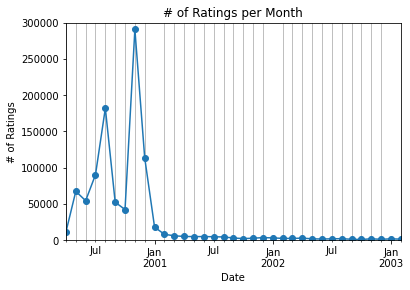

In [ ]:
month_counts = df_rating[['year', 'month', 'rating']].groupby(['year', 'month']).count()
month_counts = month_counts.rename(index=str, columns={'rating': '# of Ratings'})
month_counts = month_counts.reset_index()
month_counts['Date'] = month_counts[['year', 'month']].apply(
    lambda x: datetime(year=int(x[0]), month=int(x[1]), day=1), axis=1
)
month_counts = month_counts.set_index('Date', drop=True)
display(month_counts)
month_counts['# of Ratings'].plot(style='o-')
plt.ylabel('# of Ratings')
plt.title('# of Ratings per Month')
plt.ylim([0, 300000])
plt.gca().grid(which='minor')
plt.show()

The number of ratings had a fairly large spike in November of 2000.

year month    Rating       std
Date                                      
2000-04-01  2000     4  3.553352  1.086216
2000-05-01  2000     5  3.613447  1.142933
2000-06-01  2000     6  3.633906  1.112886
2000-07-01  2000     7  3.630073  1.091738
2000-08-01  2000     8  3.572174  1.122029
2000-09-01  2000     9  3.609717  1.117345
2000-10-01  2000    10  3.620419  1.087371
2000-11-01  2000    11  3.571671  1.130624
2000-12-01  2000    12  3.585019  1.115809
2001-01-01  2001     1  3.543657  1.064980
2001-02-01  2001     2  3.551500  1.088263
2001-03-01  2001     3  3.528358  1.053631
2001-04-01  2001     4  3.471282  1.111787
2001-05-01  2001     5  3.460822  1.052025
2001-06-01  2001     6  3.472797  1.079897
2001-07-01  2001     7  3.476600  1.078435
2001-08-01  2001     8  3.467670  1.136817
2001-09-01  2001     9  3.541111  1.048258
2001-10-01  2001    10  3.415602  1.100265
2001-11-01  2001    11  3.594203  1.083252
2001-12-01  2001    12  3.496568  1.089153
2002-01-01  2002     1  3.557525  1.071235
2002-02-01  2002     2  3.473558  1.071821
2002-03-01  2002     3  3.279951  1.121751
2002-04-01  2002     4  3.488732  1.108366
2002-05-01  2002     5  3.556782  1.127199
2002-06-01  2002     6  3.475959  1.079597
2002-07-01  2002     7  3.398425  1.101135
2002-08-01  2002     8  3.269067  1.090495
2002-09-01  2002     9  3.446249  1.072277
2002-10-01  2002    10  3.557199  1.007466
2002-11-01  2002    11  3.549266  1.042960
2002-12-01  2002    12  3.494462  1.119878
2003-01-01  2003     1  3.511339  1.181242
2003-02-01  2003     2  3.455882  1.120526

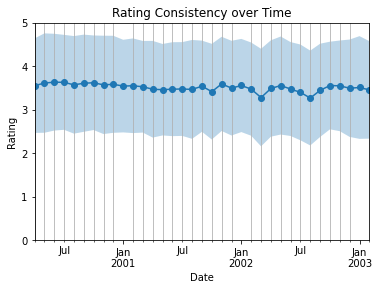

In [ ]:
month_counts = df_rating.groupby(['year', 'month'])['rating'].agg([np.mean, np.std])
month_counts = month_counts.rename(index=str, columns={'mean': 'Rating'})
month_counts = month_counts.reset_index()
month_counts['Date'] = month_counts[['year', 'month']].apply(
    lambda x: datetime(year=int(x[0]), month=int(x[1]), day=1), axis=1
)
month_counts = month_counts.set_index('Date', drop=True)
display(month_counts)
month_counts['Rating'].plot(style='o-')
plt.fill_between(month_counts.index,
                 month_counts['Rating'] - month_counts['std'],
                 month_counts['Rating'] + month_counts['std'],
                 alpha=0.3,
                )
plt.ylim([0, 5])
plt.ylabel('Rating')
plt.gca().grid(which='minor')
plt.title('Rating Consistency over Time')
plt.show()

This average ratings were fairly consistent around 3.6. 

How quickly do the movie and user bases grow over time?

user_id  movie_id  rating           timestamp  year  month       Date
1000138     6040       858       4 2000-04-25 23:05:32  2000      4 2000-04-01
1000153     6040      2384       4 2000-04-25 23:05:54  2000      4 2000-04-01
999873      6040       593       5 2000-04-25 23:05:54  2000      4 2000-04-01
1000007     6040      1961       4 2000-04-25 23:06:17  2000      4 2000-04-01
1000192     6040      2019       5 2000-04-25 23:06:17  2000      4 2000-04-01

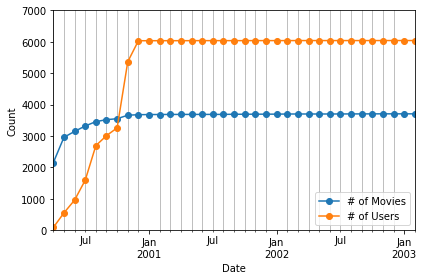

In [ ]:
df_rating['Date'] = df_rating[['year', 'month']].apply(
    lambda x: datetime(year=int(x[0]), month=int(x[1]), day=1), axis=1
)
display(df_rating.head())
n_users = []
n_movies = []
dates = np.unique(df_rating['Date'])
for date in dates:
    n_users.append(df_rating[df_rating['Date'] <= date]['user_id'].nunique())
    n_movies.append(df_rating[df_rating['Date'] <= date]['movie_id'].nunique())
df_users = pd.DataFrame({'Date': dates, '# of Users': n_users}).set_index('Date')
df_movies = pd.DataFrame({'Date': dates, '# of Movies': n_movies}).set_index('Date')
fig, ax = plt.subplots()
df_movies['# of Movies'].plot(style='o-', ax=ax)
df_users['# of Users'].plot(style='o-', ax=ax)
plt.ylabel('Count')
plt.ylim([0, 7000])
ax.grid(which='minor')
plt.tight_layout()
plt.legend()
plt.show()

The number of movies looked fairly stable as the number of users increased over time.

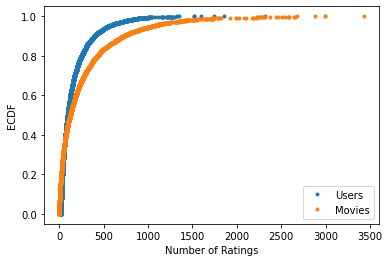

In [ ]:
user_counts = df_rating['user_id'].value_counts(ascending=True)
user_counts.index = np.arange(len(user_counts)) / len(user_counts)
plt.plot(user_counts, user_counts.index, '.', label='Users')
movie_counts = df_rating['movie_id'].value_counts(ascending=True)
movie_counts.index = np.arange(len(movie_counts)) / len(movie_counts)
plt.plot(movie_counts, movie_counts.index, '.', label='Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('ECDF')
plt.legend()
plt.show()

It is observed that 50% of all users rated 100 or less movies and 90% of movies have 1500 or less ratings.

In [ ]:
df_rating['user_id'].value_counts().nlargest(n=10)

4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
889     1518
3618    1344
2063    1323
1150    1302
1015    1286
Name: user_id, dtype: int64

We can observe that user id 4169 is the top users with 2314 reviews.

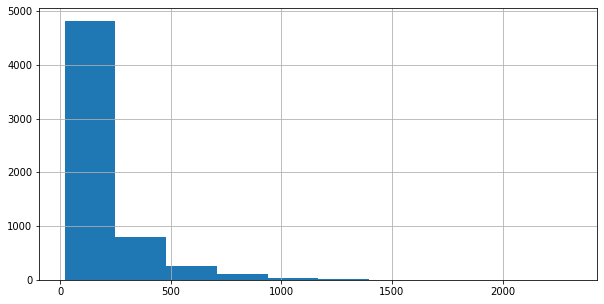

In [ ]:
df_rating['user_id'].value_counts().hist(figsize=(10, 5))

Around 4900 people have made 1 to 250 reviews and around 900 people have made 250-500 reviews. Aproximately 250-300 people have made more than 500 reviews.

In [ ]:
df_rating['movie_id'].value_counts().nlargest(n=10)

2858    3428
260     2991
1196    2990
1210    2883
480     2672
2028    2653
589     2649
2571    2590
1270    2583
593     2578
Name: movie_id, dtype: int64

Movie id 2858 has the most number of reviews. 

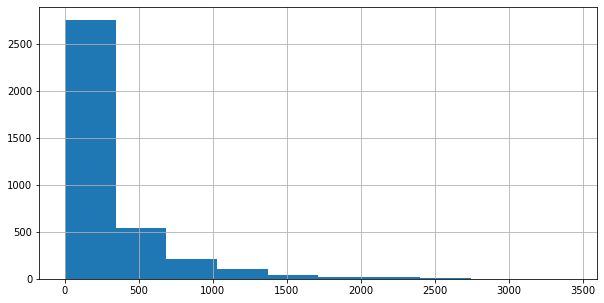

In [ ]:
df_rating['movie_id'].value_counts().hist(figsize=(10, 5));

Approximately 3000 movies have 1 to 300 reviews and the rest of the movies have more than 500 reviews.

<a name="userdata"></a>
###User Data

In [ ]:
df_user.head()

user_id gender  age  occupation zipcode
0        1      F    1          10   48067
1        2      M   56          16   70072
2        3      M   25          15   55117
3        4      M   45           7   02460
4        5      M   25          20   55455

There are 5 attriibutes for each user.

In [ ]:
print('#Unique occupation:', df_user.occupation.nunique())
print('#Unique zipcodes:', df_user.zipcode.nunique())
print('Gender distribution:\n', df_user['gender'].value_counts())

#Unique occupation: 21
#Unique zipcodes: 3439
Gender distribution:
 M    4331
F    1709
Name: gender, dtype: int64


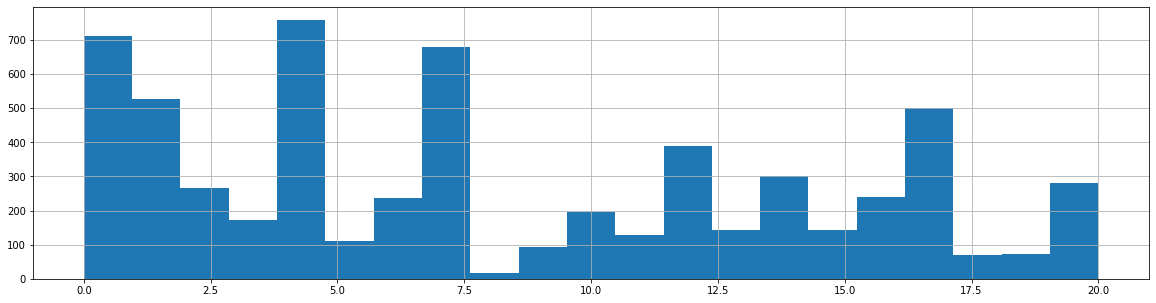

In [ ]:
df_user['occupation'].hist(bins=21, figsize=(20, 5))

Three occupations have approximately 700 users and 2 groups have 500.

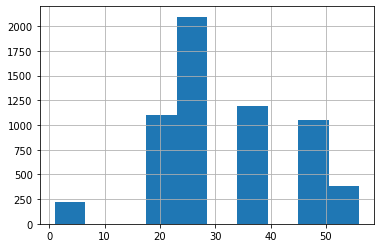

In [ ]:
df_user['age'].hist();

Approximately 2000 users are between the age of 25 to 34 and aroound 1000 people are between 18 to 24, 35 to 44, 45 to 49.

<a name="moviedata"></a>
###Movie Data

In [ ]:
df_movie.head()

movie_id                               title                         genre
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy

In [ ]:
df_movie['release_year'] = df_movie.title.str.extract("\((\d{4})\)", expand=True).astype(str)

In [ ]:
df_movie['release_year'] = pd.to_datetime(df_movie.release_year, format='%Y')
df_movie['release_year'] = df_movie.release_year.dt.year
df_movie['title'] = df_movie.title.str[:-7]

We observed that the year of release is in the title column. We split it and create a release_year column.

In [ ]:
genres_unique = pd.DataFrame(df_movie.genre.str.split('|').tolist()).stack().unique()
print('Unique genres', genres_unique)
genres_unique = pd.DataFrame(genres_unique, columns=['genre'])

Unique genres ['Animation' "Children's" 'Comedy' 'Adventure' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Sci-Fi' 'Documentary' 'War'
 'Musical' 'Mystery' 'Film-Noir' 'Western']


In [ ]:
df_movie = df_movie.join(df_movie.genre.str.get_dummies().astype(bool))
df_movie.drop('genre', inplace=True, axis=1)

We create dummy columns for boolean values.

In [ ]:
df_movie.head()

movie_id                        title  ...    War  Western
0         1                    Toy Story  ...  False    False
1         2                      Jumanji  ...  False    False
2         3             Grumpier Old Men  ...  False    False
3         4            Waiting to Exhale  ...  False    False
4         5  Father of the Bride Part II  ...  False    False

[5 rows x 21 columns]

In [ ]:
print('#Unique movie release years:', df_movie.release_year.nunique())


#Unique movie release years: 81


In [ ]:
temp = df_movie.release_year.unique()
temp.sort()
print(temp)

[1919 1920 1921 1922 1923 1925 1926 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947
 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961
 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975
 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000]


We can observe that there are 3883 movies with release years from 1919 to 2000.

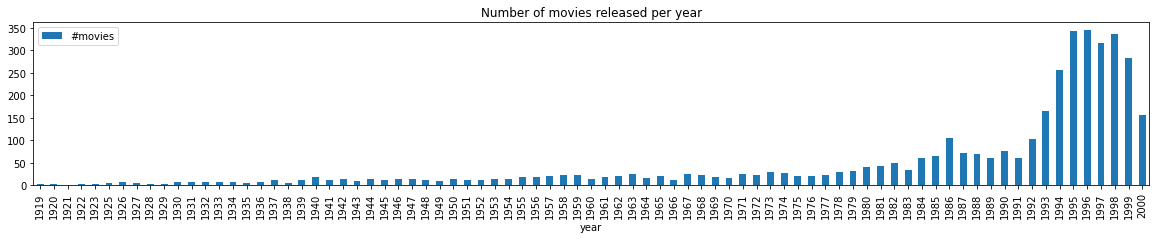

In [ ]:
df_temp = df_movie[['release_year', 'movie_id']].groupby(['release_year']).count().reset_index().rename(columns={'release_year':'year', 'movie_id':'#movies'})
df_temp.plot.bar('year', '#movies', title='Number of movies released per year', figsize=(20, 3));

Most movies were released during the 90s. 

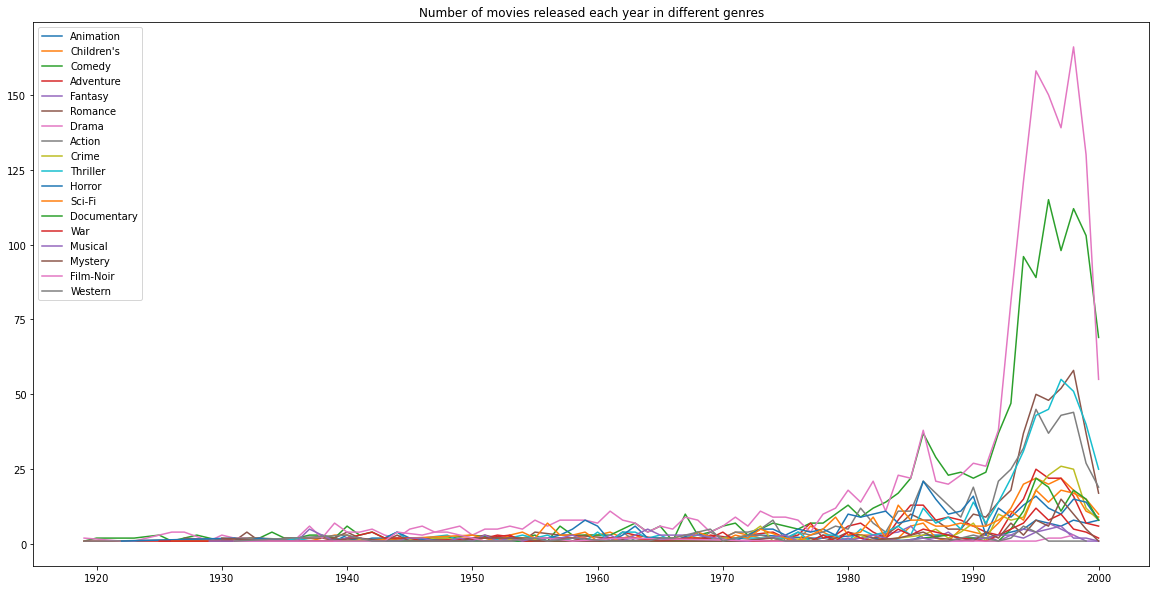

In [ ]:
plt.figure(figsize=(20,10)) 
for genre in genres_unique.genre:
    df_temp = df_movie[df_movie[genre]==True][['release_year', 'movie_id']]
    df_temp = df_temp.groupby(['release_year']).count().reset_index().rename(columns={'release_year':'year', 'movie_id':'#movies'})
    plt.plot(df_temp['year'], df_temp['#movies'], label=genre)
plt.title('Number of movies released each year in different genres')
plt.legend()
plt.show()

There are a large number of Film-Noir and comedy movies in the late 90s.

<a name="overview"></a>
###Overview

In [ ]:
df_temp = df_rating.merge(df_movie, left_on='movie_id', right_on='movie_id', how='left')
df_final = df_temp.merge(df_user, left_on='user_id', right_on='user_id', how='left')
df_final.head()

user_id  movie_id  rating  ... age  occupation  zipcode
0     6040       858       4  ...  25           6    11106
1     6040      2384       4  ...  25           6    11106
2     6040       593       5  ...  25           6    11106
3     6040      1961       4  ...  25           6    11106
4     6040      2019       5  ...  25           6    11106

[5 rows x 31 columns]

We combined the rating, user and movie data.

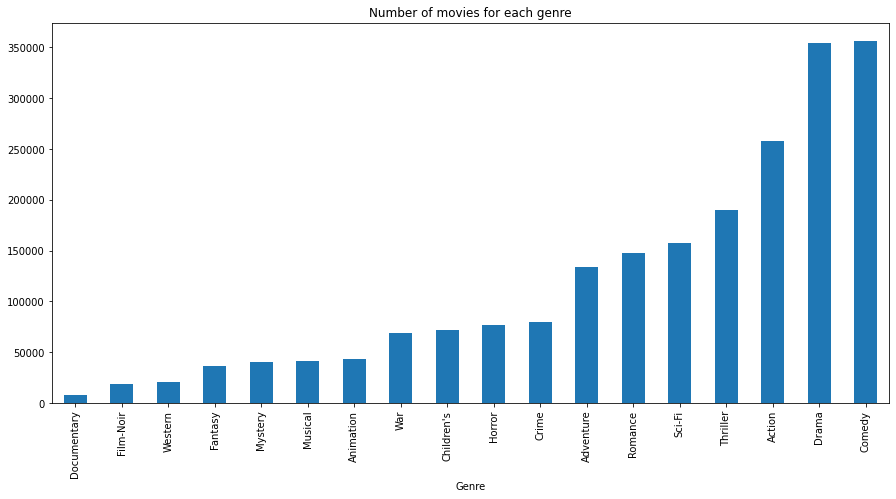

In [ ]:
df_temp = pd.DataFrame(columns=['genre', 'num_movies'])
for genre in genres_unique.genre:
    row = [genre, df_final[df_final[genre]==True][['movie_id']].count()]
    df_temp.loc[len(df_temp)] = row
df_temp['num_movies'] = df_temp['num_movies'].astype(np.int32)
df_temp = df_temp.sort_values('num_movies', ascending=True).set_index('genre')
plot_fig = df_temp['num_movies'].plot(kind='bar', figsize=(15,7))
plot_fig.set_title('Number of movies for each genre')
plot_fig.set_xlabel('Genre');

Comedy and Drama have the highest number of movies followed by Action and Thriller.

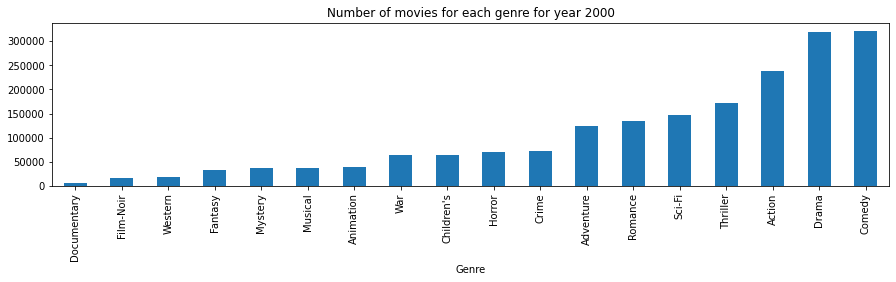

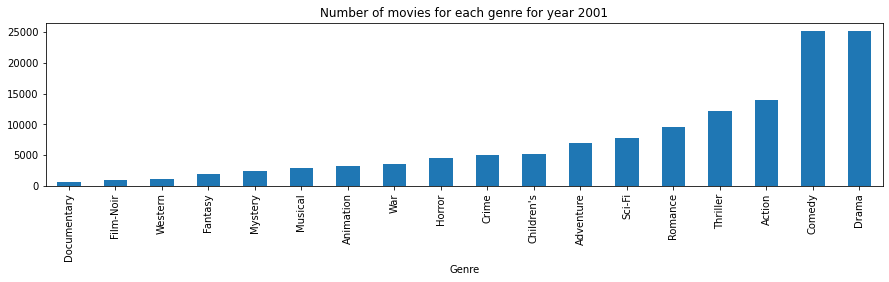

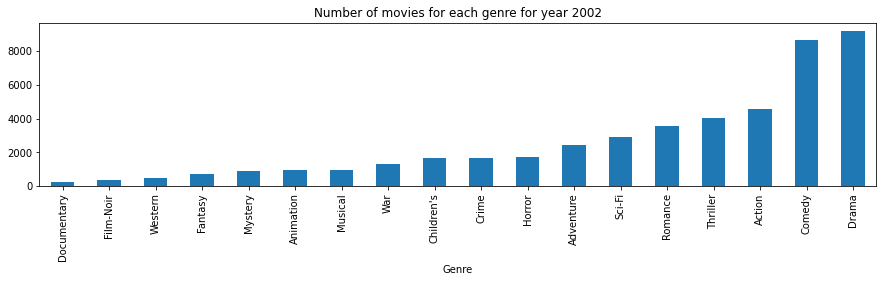

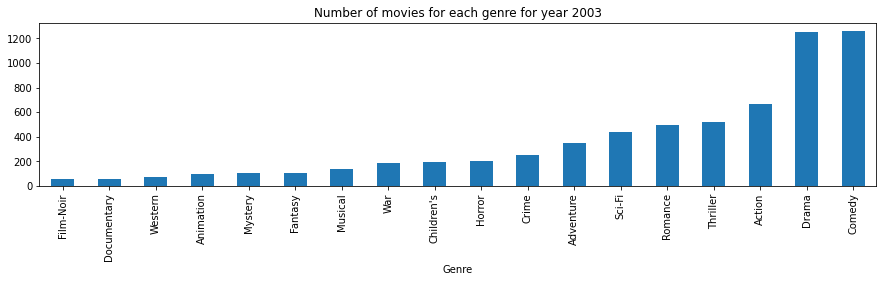

In [ ]:
for year in df_final['year'].unique():
    df_year = df_final[df_final['year']==year]
    df_temp = pd.DataFrame(columns=['genre', 'num_movies'])
    for genre in genres_unique.genre:
        row = [genre, df_year[df_year[genre]==True][['movie_id']].count()]
        df_temp.loc[len(df_temp)] = row
    df_temp['num_movies'] = df_temp['num_movies'].astype(np.int32)
    df_temp = df_temp.sort_values('num_movies', ascending=True).set_index('genre')
    plot_fig = df_temp['num_movies'].plot(kind='bar', figsize=(15,3))
    plot_fig.set_title('Number of movies for each genre for year %s'%year)
    plot_fig.set_xlabel('Genre')
    plt.show()

The trend of each genre is similar over the years.

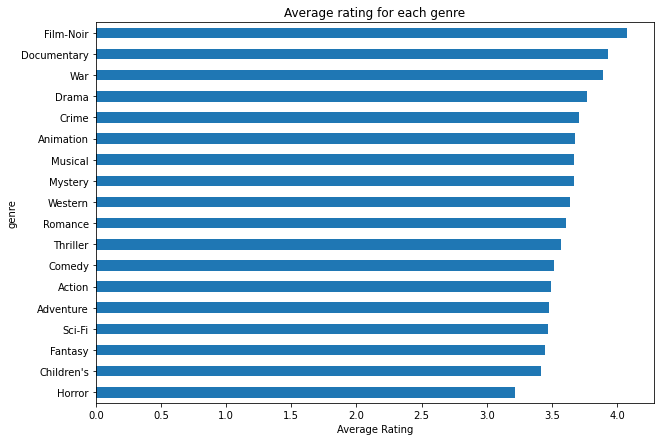

In [ ]:
df_temp = pd.DataFrame(columns=['genre', 'avg_rating'])
for genre in genres_unique.genre:
    row = [genre, round(df_final[df_final[genre]==True][['rating']].mean(), 2).to_string()[6:]]
    df_temp.loc[len(df_temp)] = row
df_temp['avg_rating'] = pd.to_numeric(df_temp['avg_rating'])
df_temp = df_temp.sort_values('avg_rating', ascending=True).set_index('genre')
plot_fig = df_temp['avg_rating'].plot(kind='barh', figsize=(10,7))
plot_fig.set_title('Average rating for each genre')
plot_fig.set_xlabel('Average Rating');

Film-Noir has the highest average rating followed by Documentary and War. Horror have the lowest average rating compared to all the other genres. 

In [ ]:
print(round(df_final.groupby(['gender'])['rating'].mean(), 2))

gender
F    3.62
M    3.57
Name: rating, dtype: float64


Women have a slightly higher rating.

Text(0.5, 0, 'Average Rating')

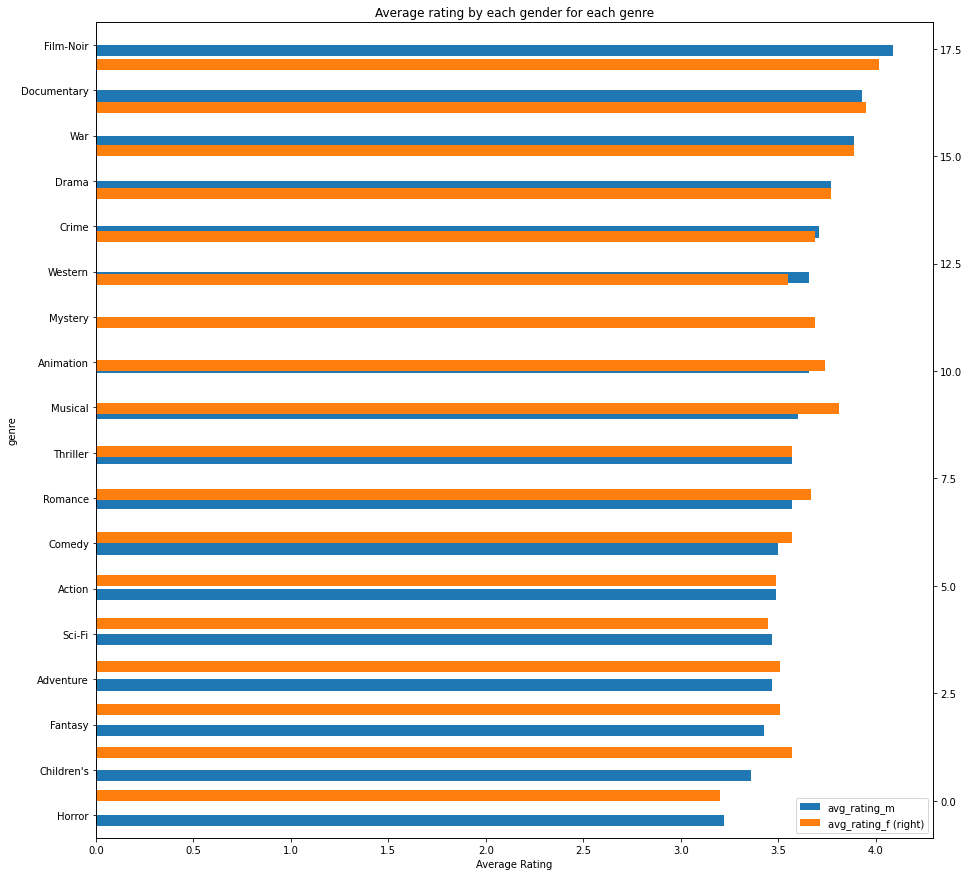

In [ ]:
df_temp = pd.DataFrame(columns=['genre', 'avg_rating_m', 'avg_rating_f'])
for genre in genres_unique.genre:
    rating_m = round(df_final[(df_final[genre]==True) & (df_final['gender']=='M')][['rating']].mean(), 2).to_string()[6:]
    rating_f = round(df_final[(df_final[genre]==True) & (df_final['gender']=='F')][['rating']].mean(), 2).to_string()[6:]
    row = [genre, rating_m, rating_f]
    df_temp.loc[len(df_temp)] = row
    
cols = ['avg_rating_m', 'avg_rating_f']
df_temp[cols] = df_temp[cols].apply(pd.to_numeric, errors='coerce', axis=1)
df_temp = df_temp.sort_values('avg_rating_m', ascending=True).set_index('genre')
plot_fig = df_temp.plot( kind= 'barh' , secondary_y= 'avg_rating_f', figsize=(15,15))
plot_fig.set_title('Average rating by each gender for each genre')
plot_fig.set_xlabel('Average Rating')

There isn't a large discrepancy in the average rating of men and women in different genres.

In [ ]:
print(round(df_final.groupby(['age'])['rating'].mean(), 2))

age
1     3.55
18    3.51
25    3.55
35    3.62
45    3.64
50    3.71
56    3.77
Name: rating, dtype: float64


There is a slight positive trend as the age group increased. 

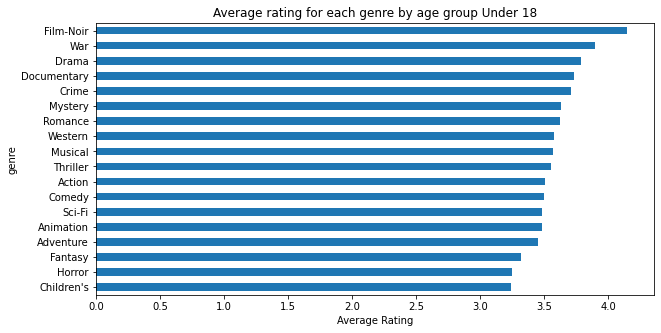

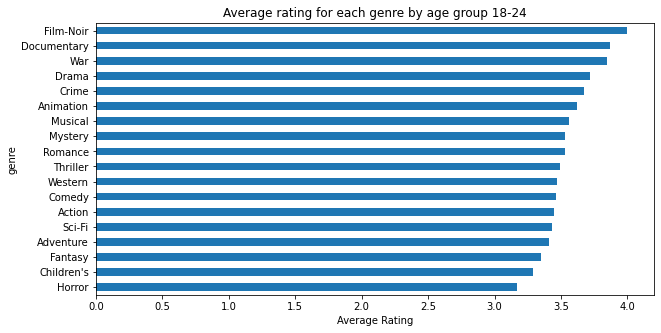

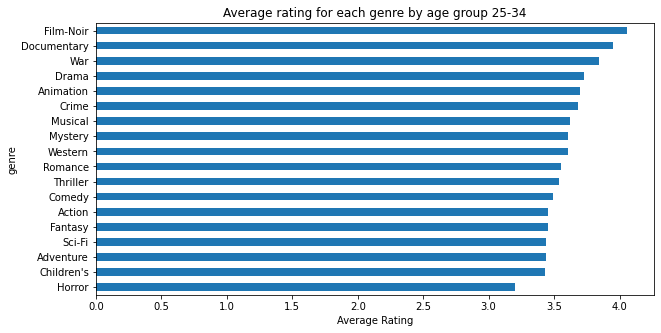

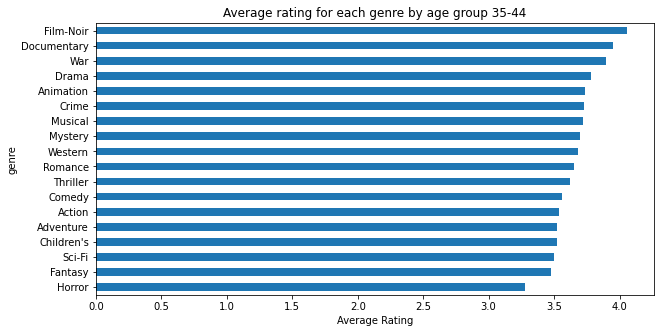

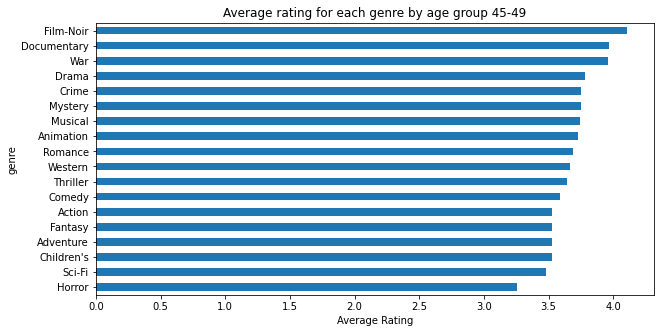

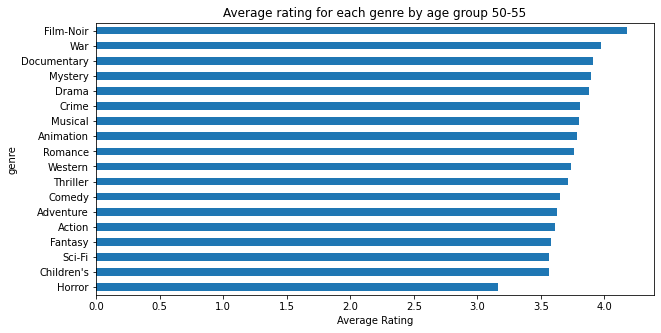

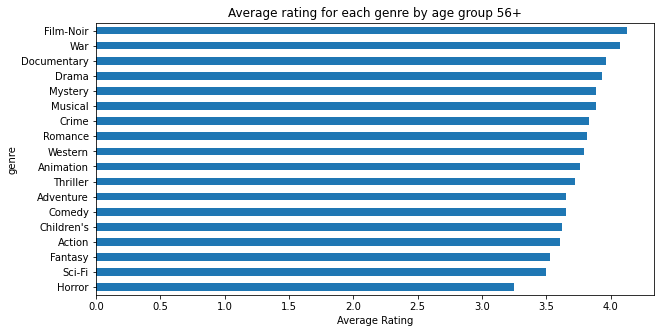

In [ ]:
for age in sorted(df_user.age.unique()):
    df_temp = pd.DataFrame(columns=['genre', 'avg_rating'])
    df_final_temp = df_final[df_final['age']==age]
    for genre in genres_unique.genre:
        row = [genre, round(df_final_temp[df_final_temp[genre]==True][['rating']].mean(), 2).to_string()[6:]]
        df_temp.loc[len(df_temp)] = row
    df_temp['avg_rating'] = pd.to_numeric(df_temp['avg_rating'])
    df_temp = df_temp.sort_values('avg_rating', ascending=True).set_index('genre')
    plot_fig = df_temp['avg_rating'].plot(kind='barh', figsize=(10,5))
    plot_fig.set_title('Average rating for each genre by age group %s'%age_group_dict[age])
    plot_fig.set_xlabel('Average Rating')
    plt.show()

Film-Nior is rated high between all age groups. However tthe under age 18 group, children movies are rated the lowest. Horror movies are rated the lowest across all age groups.

In [ ]:
df_temp = pd.DataFrame(columns=['occupation', 'avg_rating'])
for occ in occupation_dict.keys():
    row = [occupation_dict[occ], round(df_final[df_final['occupation'] == occ]['rating'].mean(), 2)]
    df_temp.loc[len(df_temp)] = row
df_temp = df_temp.sort_values('avg_rating', ascending=False).reset_index(drop=True)
df_temp

occupation  avg_rating
0                  retired        3.78
1                scientist        3.69
2           clerical/admin        3.66
3       doctor/health care        3.66
4                homemaker        3.66
5               programmer        3.65
6          sales/marketing        3.62
7                   lawyer        3.62
8      technician/engineer        3.61
9            self-employed        3.60
10    executive/managerial        3.60
11       academic/educator        3.58
12                  artist        3.57
13  other or not specified        3.54
14        customer service        3.54
15    college/grad student        3.54
16     tradesman/craftsman        3.53
17            K-12 student        3.53
18                  writer        3.50
19                  farmer        3.47
20              unemployed        3.41

People who are retired gave a slightly higher rating.Scientist gave the second highest rating then clerics and doctors.

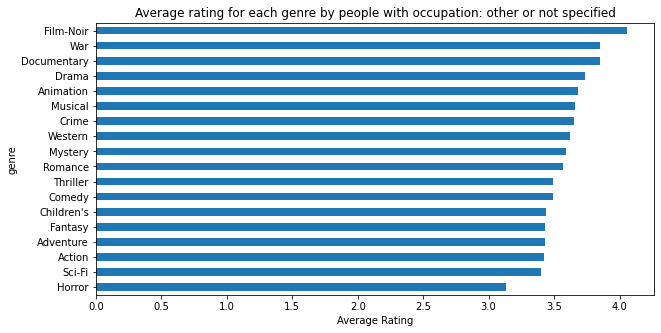

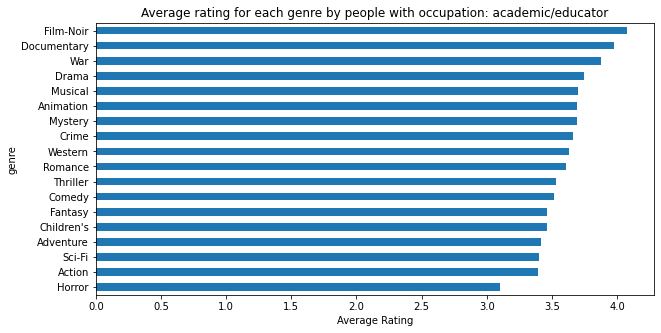

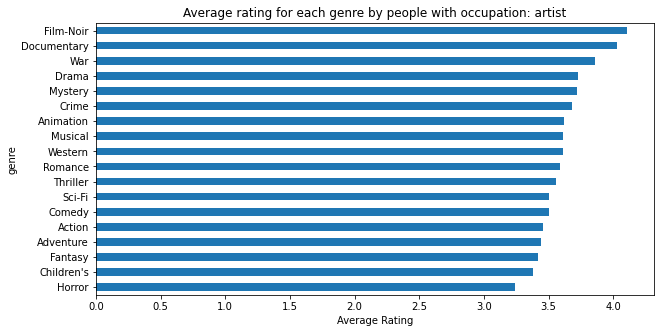

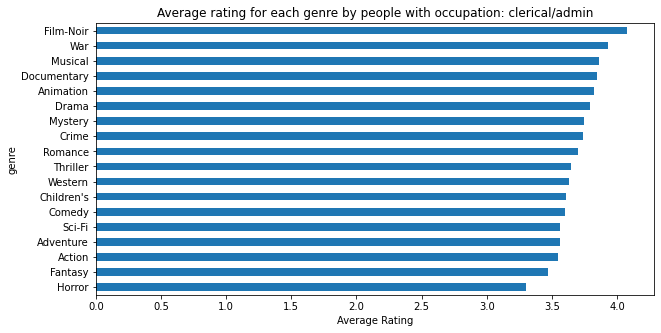

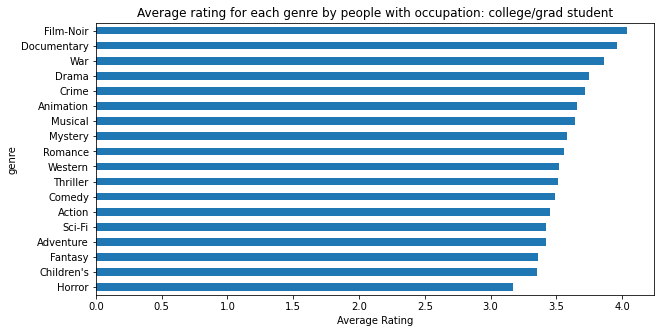

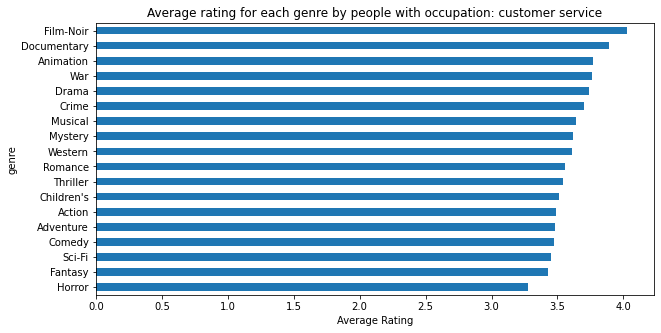

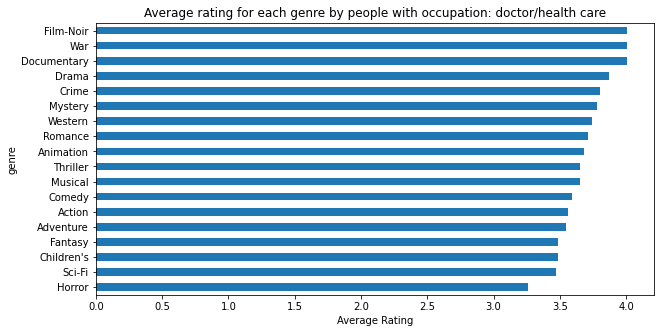

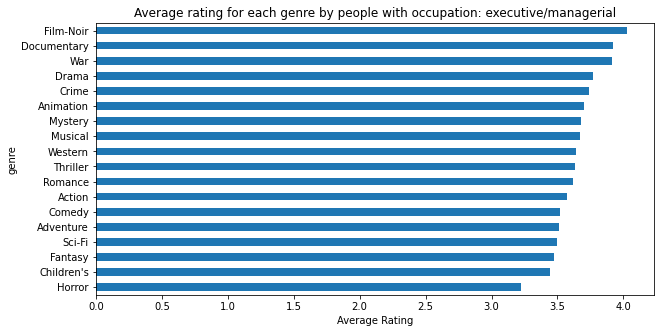

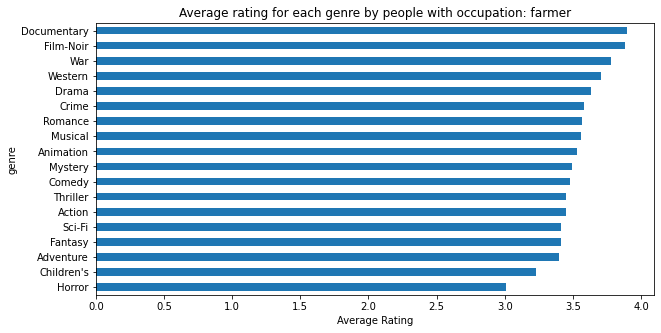

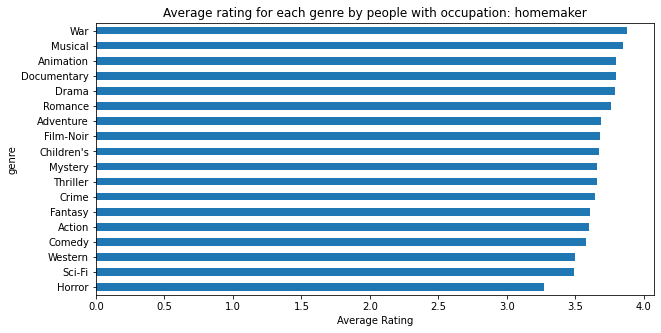

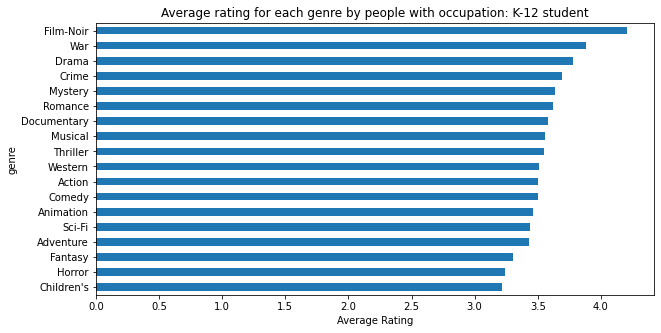

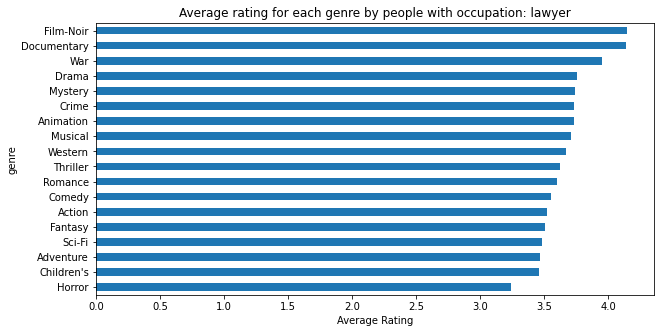

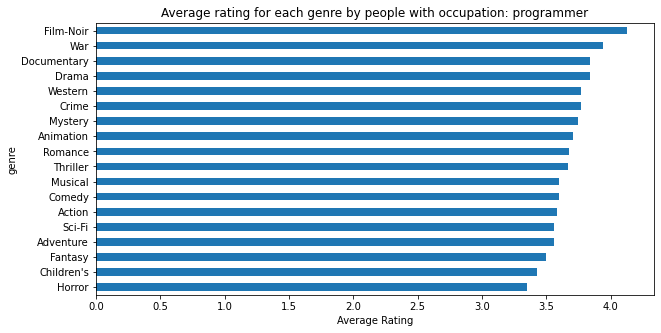

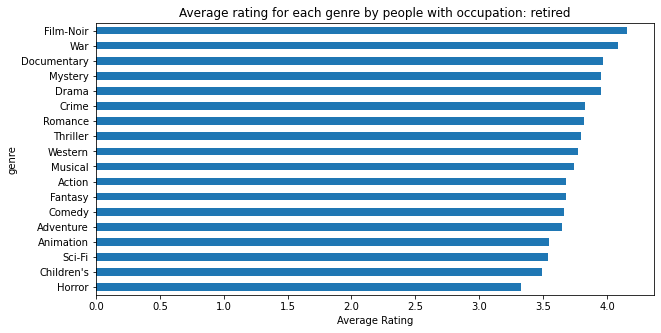

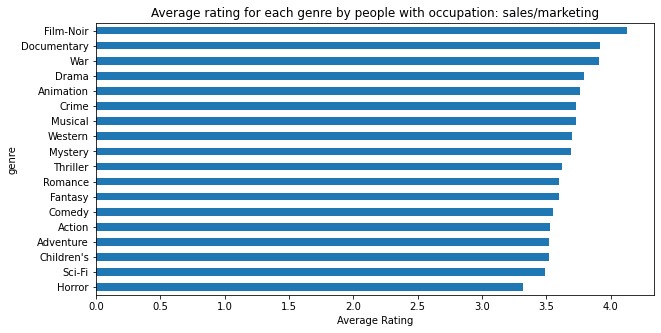

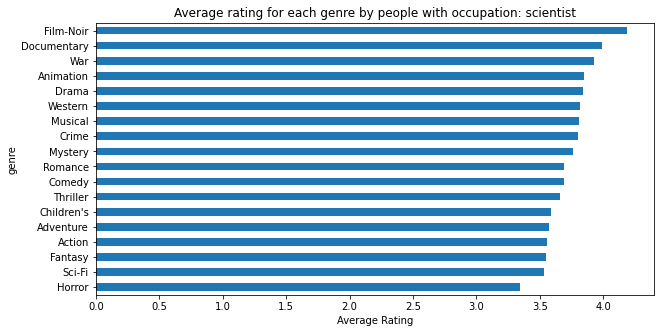

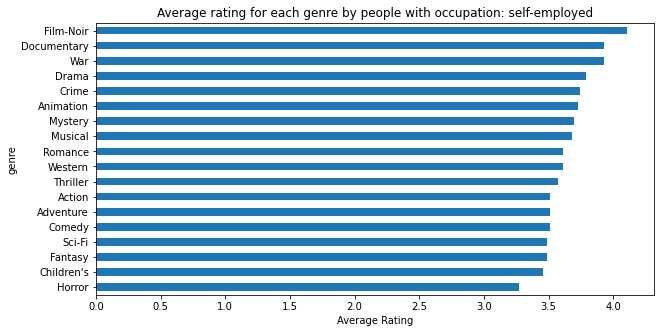

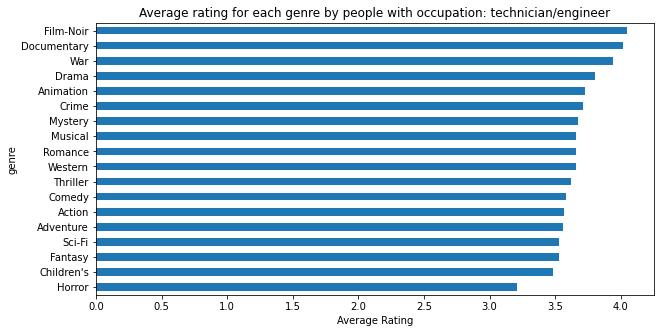

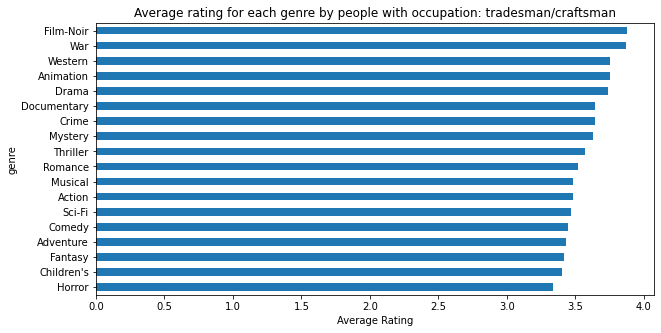

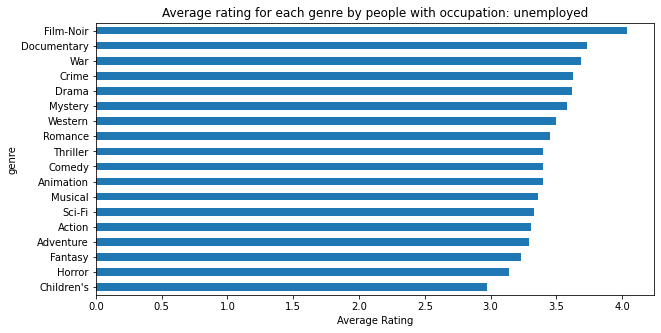

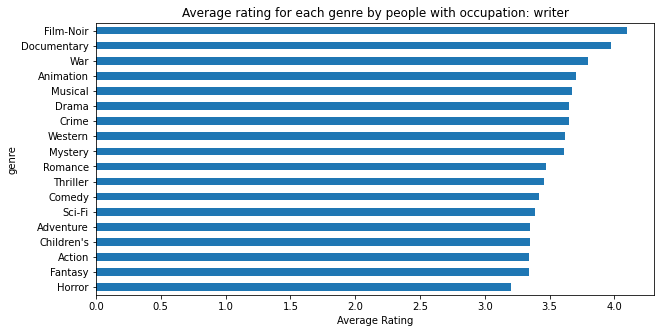

In [ ]:
for occ in sorted(df_user.occupation.unique()):
    df_temp = pd.DataFrame(columns=['genre', 'avg_rating'])
    df_final_temp = df_final[df_final['occupation']==occ]
    for genre in genres_unique.genre:
        row = [genre, round(df_final_temp[df_final_temp[genre]==True][['rating']].mean(), 2).to_string()[6:]]
        df_temp.loc[len(df_temp)] = row
    df_temp['avg_rating'] = pd.to_numeric(df_temp['avg_rating'])
    df_temp = df_temp.sort_values('avg_rating', ascending=True).set_index('genre')
    plot_fig = df_temp['avg_rating'].plot(kind='barh', figsize=(10,5))
    plot_fig.set_title('Average rating for each genre by people with occupation: %s'%occupation_dict[occ])
    plot_fig.set_xlabel('Average Rating')
    plt.show()

Most occupation types like the Film-Noir genre except for farmers and homemakers. 

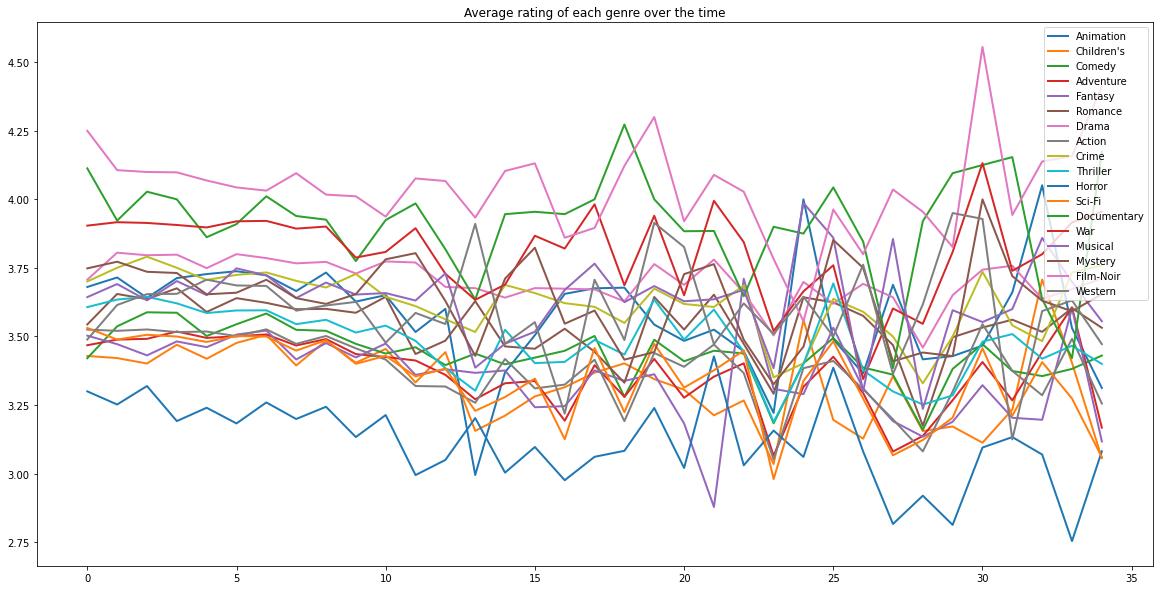

In [ ]:
plt.figure(figsize=(20,10)) 
for genre in genres_unique.genre:
    df_temp = df_final[df_final[genre]==True][['year', 'month', 'rating']]
    df_temp = df_temp.groupby(['year', 'month'])['rating'].agg([np.mean]).reset_index()
    plt.plot(df_temp['mean'], linewidth=2.0, label=genre)
plt.title('Average rating of each genre over the time')
plt.legend()
plt.show()

Film-Noir consistently have high ratings where as horror movies have always have low ratings

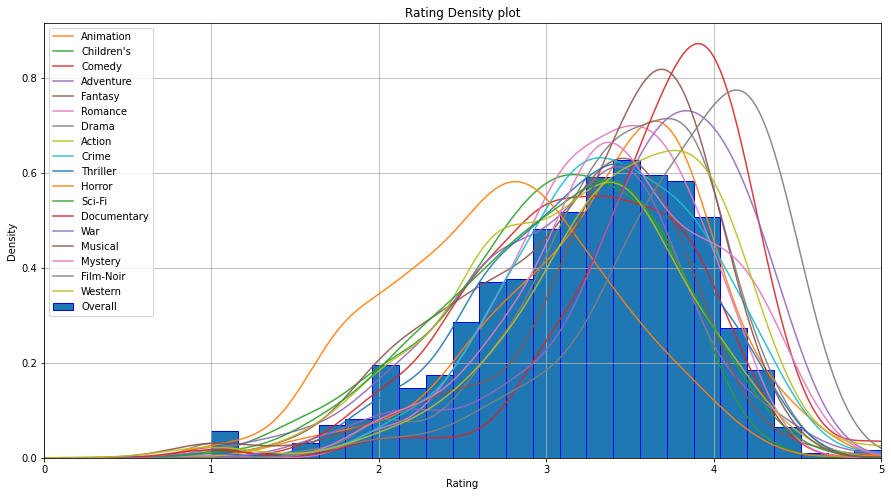

In [ ]:
df_temp = df_final[['movie_id','rating']].groupby('movie_id').mean()

# Histogram of all ratings
df_temp.hist(bins=25, grid=False, edgecolor='b', density=True, label ='Overall', figsize=(15,8))

# KDE plot per genre
for genre in genres_unique.genre:
    df_temp = df_final[df_final[genre]==True][['movie_id','rating']].groupby('movie_id').mean()
    df_temp.rating.plot(grid=True, alpha=0.9, kind='kde', label=genre)
plt.legend()
plt.xlim(0,5)
plt.xlabel('Rating')
plt.title('Rating Density plot')
plt.show()

All genres have a left-skewed distribution except for the low-rated horror genre.

<a name="Preprocessing"></a>
# Preprocessing

In [ ]:
RATINGS_CSV_FILE = 'ml1m_ratings.csv'
USERS_CSV_FILE = 'ml1m_users.csv'
MOVIES_CSV_FILE = 'ml1m_movies.csv'

We transform the raw data to a csv file with headers. The movie and user id will be subtracted by 1 for zero-based index. 

In [ ]:
df_ratings = pd.read_csv('/content/drive/MyDrive/movielens /ml-1m/ratings.dat', sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'movie_id', 'rating', 'timestamp'])
                        # sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'])
max_userid = df_ratings['user_id'].drop_duplicates().max()
max_movieid = df_ratings['movie_id'].drop_duplicates().max()
df_ratings['user_emb_id'] = df_ratings['user_id'] - 1
df_ratings['movie_emb_id'] = df_ratings['movie_id'] - 1
print(len(df_ratings), 'ratings loaded')
df_ratings.to_csv(RATINGS_CSV_FILE, 
               sep='\t', 
               header=True, 
               encoding='latin-1', 
               columns=['user_emb_id', 'movie_emb_id', 'rating', 'timestamp'])
print('Saved to', RATINGS_CSV_FILE)

df_users = pd.read_csv('/content/drive/MyDrive/movielens /ml-1m/users.dat', sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])
                      # sep='::', header=None, names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])
df_users['age_desc'] = df_users['age'].apply(lambda x: age_group_dict[x])
df_users['occ_desc'] = df_users['occupation'].apply(lambda x: occupation_dict[x])
print(len(df_users), 'descriptions of', max_userid, 'users loaded.')
df_users['user_emb_id'] = df_users['user_id'] - 1
df_users.to_csv(USERS_CSV_FILE, 
             sep='\t', 
             header=True, 
             encoding='latin-1',
             columns=['user_emb_id', 'gender', 'age', 'occupation', 'zipcode', 'age_desc', 'occ_desc'])
print('Saved to', USERS_CSV_FILE)

df_movies = pd.read_csv('/content/drive/MyDrive/movielens /ml-1m/movies.dat', sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genre'])
                      #  sep='::', header=None, names=['movie_id', 'title', 'genre'])
print(len(df_movies), 'descriptions of', max_movieid, 'movies loaded.')
df_movies['movie_emb_id'] = df_movies['movie_id'] - 1
df_movies.to_csv(MOVIES_CSV_FILE, 
              sep='\t', 
              header=True, 
              columns=['movie_emb_id', 'title', 'genre'])
print('Saved to', MOVIES_CSV_FILE)

1000209 ratings loaded
Saved to ml1m_ratings.csv
6040 descriptions of 6040 users loaded.
Saved to ml1m_users.csv
3883 descriptions of 3952 movies loaded.
Saved to ml1m_movies.csv


In [ ]:
print(len(df_ratings['user_id'].drop_duplicates()), 'of the', max_userid, 'users rate at least one movie.')

6040 of the 6040 users rate at least one movie.


In [ ]:
print(len(df_ratings['movie_id'].drop_duplicates()), 'of the', max_movieid, 'movies are rated.')

3706 of the 3952 movies are rated.


In [ ]:
df = pd.read_csv('ml1m_ratings.csv',sep='\t', encoding='latin-1', 
                      usecols=['user_emb_id', 'movie_emb_id', 'rating', 'timestamp'])
num_users = df['user_emb_id'].unique().max() + 1
num_movies = df['movie_emb_id'].unique().max() + 1
df.head(5)

user_emb_id  movie_emb_id  rating  timestamp
0            0          1192       5  978300760
1            0           660       3  978302109
2            0           913       3  978301968
3            0          3407       4  978300275
4            0          2354       5  978824291

Train, Validation and Test Split
We split the data into random 90%–10% train-test sets, and hold out 10% of the training set for validation.

In [ ]:
train_df, test_df = train_test_split(df,
                                     stratify=df['user_emb_id'],
                                     test_size=0.1,
                                     random_state=999613182)

In [ ]:
train_df.head(5)

user_emb_id  movie_emb_id  rating  timestamp
339280         1997          1018       2  974679219
881301         5322          1293       4  960848231
926190         5597          2293       4  959214335
726548         4344            26       2  966273825
153039          983          3860       3  975115869

In [ ]:
train_df, validate_df = train_test_split(train_df,
                                 stratify=train_df['user_emb_id'],
                                 test_size=0.1,
                                 random_state=999613182)

We stratify the user_id because without it the reviews of one user are all split into one the training or test set and that can cause bias. For example if all the reviews of user A are put into the training set, then during test time, there is no test data for this user. The test RMSE will be 0 for this user. On the other hand, if all reviews are put into test set, then there is no review for this user during training time and cause the RMSE higher for this user.

Transform dataframe to matrix

In [ ]:
def dataPreprocessor(rating_df, num_users, num_items, init_value=0, average=False):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
    """
    if average:
      matrix = np.full((num_users, num_items), 0.0)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating
      avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
      inds = np.where(matrix == 0)
      matrix[inds] = np.take(avergae, inds[0])
      
    else:
      matrix = np.full((num_users, num_items), init_value)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating

    return matrix

In [ ]:
# Creating a sparse pivot table with users in rows and items in columns
users_items_matrix_train_zero = dataPreprocessor(train_df, num_users, num_movies, 0)
users_items_matrix_train_one = dataPreprocessor(train_df, num_users, num_movies, 1)
users_items_matrix_train_two = dataPreprocessor(train_df, num_users, num_movies, 2)
users_items_matrix_train_four = dataPreprocessor(train_df, num_users, num_movies, 4)
users_items_matrix_train_three = dataPreprocessor(train_df, num_users, num_movies, 3)
users_items_matrix_train_five = dataPreprocessor(train_df, num_users, num_movies, 5)
users_items_matrix_validate = dataPreprocessor(validate_df, num_users, num_movies, 0)
users_items_matrix_test = dataPreprocessor(test_df, num_users, num_movies, 0)

In [ ]:
users_items_matrix_train_average = dataPreprocessor(train_df, num_users, num_movies, average=True)

Before we apply AutoRec to the dataset, the dataset should be transformed to a MxN matrix where *m* is the user and *n* is the item.

<a name="Methods"></a>
# Methods


In [ ]:
def show_error(history, skip):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(np.arange(skip, len(loss), 1), loss[skip:])
    plt.plot(np.arange(skip, len(loss), 1), val_loss[skip:])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [ ]:
def show_rmse(history, skip):
    rmse = history.history['masked_rmse_clip']
    val_rmse = history.history['val_masked_rmse_clip']
    plt.plot(np.arange(skip, len(rmse), 1), rmse[skip:])
    plt.plot(np.arange(skip, len(val_rmse), 1), val_rmse[skip:])
    plt.title('model train vs validation masked_rmse')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [ ]:
def load_model(name):
  # load json and create model
  model_file = open('{}.json'.format(name), 'r')
  loaded_model_json = model_file.read()
  model_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights("{}.h5".format(name))
  print("Loaded model from disk")
  return loaded_model

In [ ]:
def save_model(name, model):
  # # serialize model to JSON
  model_json = model.to_json()
  with open("{}.json".format(name), "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights("{}.h5".format(name))
  print("Saved model to disk")

In [ ]:
def masked_se(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1)
        return masked_mse

I followed the AutoRec paper to minimize the Masked Mean Squared Error(MMSE).

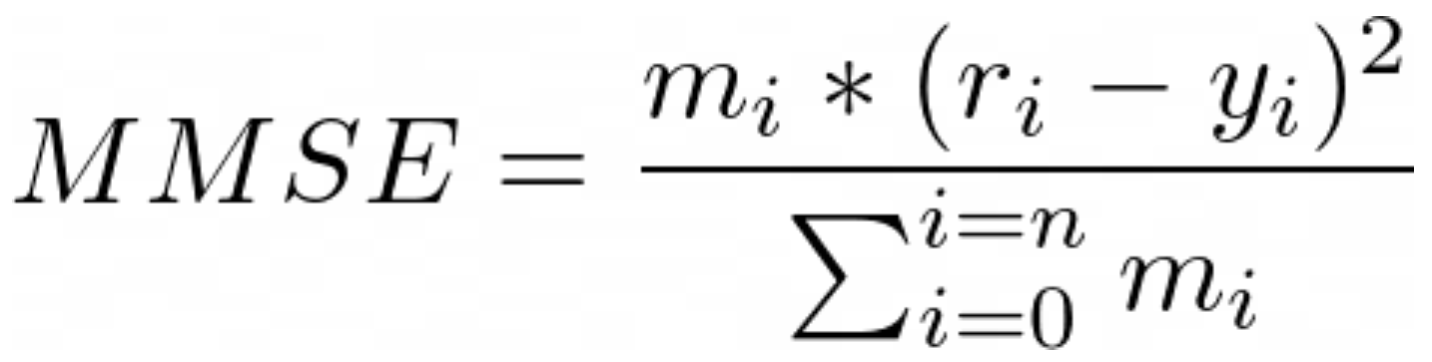

where *ri* is the actual rating and *yi* is the reconstructed rating. *mi* is a mask function where *mi*=1 where *ri* is non-zero else *mi*=0.

In [ ]:
def masked_mse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse

In [ ]:
def masked_rmse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

I measured the performance of the model by the Masked Root Mean Squared Error (MRMSE). Similar to MMSE, we only take into consideration the error where the rating is not zero in the test set. Also, I clip the predicted rating with 1 as minimum and 5 as maximum.


In [ ]:
def masked_rmse_clip(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 5)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

In [ ]:
# Test custom cost function
y_pred = K.constant([[ 1, 1, 1, 1], 
                     [ 1, 1, 1, 10],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3]])
y_pred = K.constant([[ 1, 1, 1, 3]])
y_true = K.constant([[ 1, 1, 1, 1],
                     [ 1, 1, 1, 1],
                     [ 0, 1, 1, 1],
                     [ 0, 0, 1, 1],
                     [ 0, 0, 0, 1],
                     [ 0, 0, 0, 0]])
y_true = K.constant([[ 0, 0, 1, 1]])
true = K.eval(y_true)
pred = K.eval(y_pred)
loss = K.eval(masked_se(y_true, y_pred))
rmse = K.eval(masked_rmse(y_true, y_pred))

for i in range(true.shape[0]):
    print(true[i], pred[i], loss[i], rmse[i], sep='\t')


[0. 0. 1. 1.]	[1. 1. 1. 3.]	4.0	1.4142135


<a name="Autorec"></a>
###Autorec: Autoencoders meet collaborative filtering [2] [8]

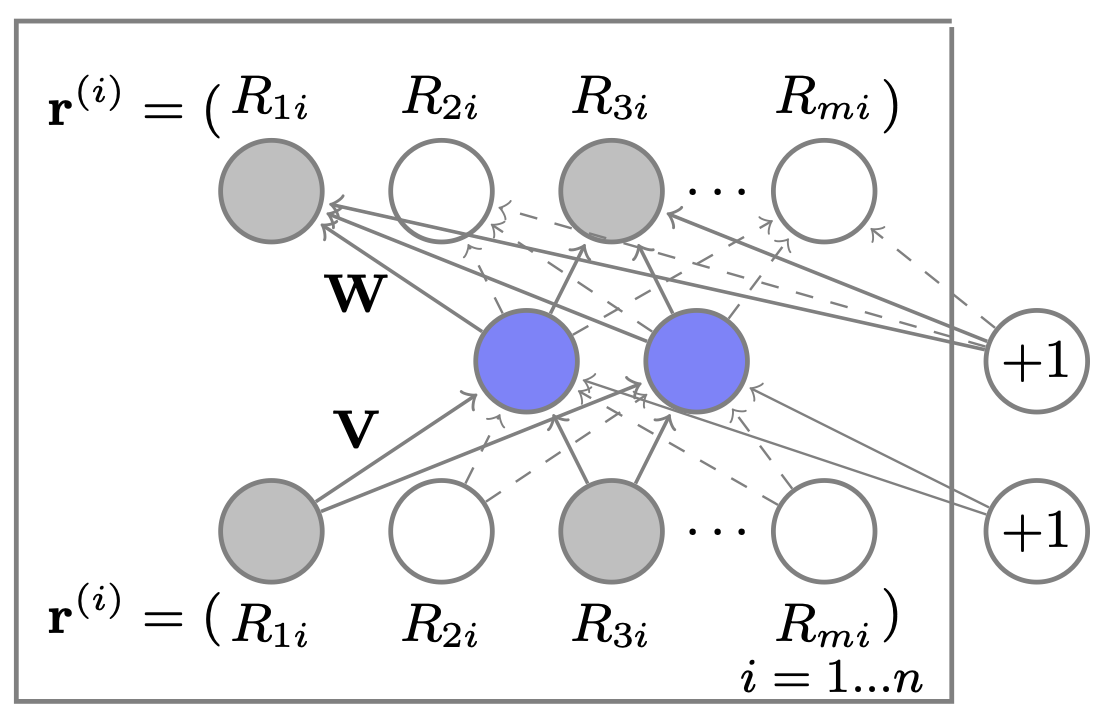
Figure 1 from the paper illustrates the structure of I-AutoRec. The shaded nodes correspond to observed ratings, and the solid connections correspond to weights that are updated for the input rᵢ.


Given the input rᵢ, the reconstruction is:
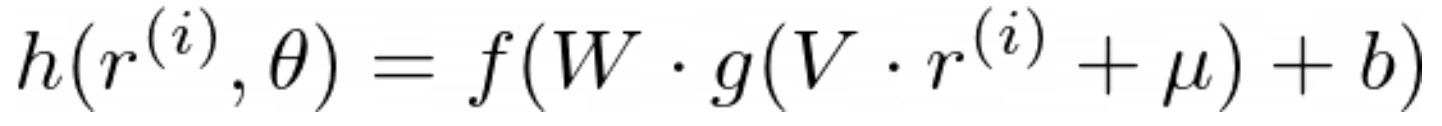
where f and g are the activation functions, and the parameter Theta includes W, V, mu, and b.


I implemented the user-based AutoRec model. The model takes the ratings vector of the user and turns it into a low dimensional latent space and then reconstructs back to an output that predicts the missing rating.

In [ ]:
def AutoRec(X, reg, first_activation, last_activation):
  
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    x = Dense(500, activation=first_activation, name='LatentSpace', kernel_regularizer=regularizers.l2(reg))(x)
    output_layer = Dense(X.shape[1], activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(reg))(x)
    model = Model(input_layer, output_layer)

    return model

Baseline model

I first used the sigmoid and linear activation as shown in the paper with an L2 regularization of 0.0005, an Adam optimizer, with a 0.0001 learning rate, 500 epochs, batch size of 256 and default rating of 3.

In [ ]:
# Build model

AutoRec = AutoRec(users_items_matrix_train_zero, 0.0005, 'sigmoid', 'linear')

AutoRec.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
LatentSpace (Dense)          (None, 500)               1976500   
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1979952   
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# users_items_matrix_train_average = users_items_matrix_train_average.astype(np.int64)# tf.cast(users_items_matrix_train_average, tf.float32)
print(users_items_matrix_train_three.dtype)
print(users_items_matrix_train_zero.dtype)
users_items_matrix_train_zero=users_items_matrix_train_zero.astype(np.float64)
users_items_matrix_validate= users_items_matrix_validate.astype(np.float64)
print(users_items_matrix_validate.dtype)
hist_Autorec = AutoRec.fit(users_items_matrix_train_three, users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=(users_items_matrix_train_three, users_items_matrix_validate))

int64
int64
float64
Epoch 1/500
24/24 - 4s - loss: 12.9878 - masked_rmse_clip: 2.8764 - val_loss: 10.5418 - val_masked_rmse_clip: 2.7943
Epoch 2/500
24/24 - 0s - loss: 8.7472 - masked_rmse_clip: 2.6583 - val_loss: 6.9380 - val_masked_rmse_clip: 2.3949
Epoch 3/500
24/24 - 0s - loss: 5.6891 - masked_rmse_clip: 2.1709 - val_loss: 4.5007 - val_masked_rmse_clip: 1.8727
Epoch 4/500
24/24 - 0s - loss: 3.7444 - masked_rmse_clip: 1.6951 - val_loss: 3.0555 - val_masked_rmse_clip: 1.4643
Epoch 5/500
24/24 - 0s - loss: 2.6460 - masked_rmse_clip: 1.3532 - val_loss: 2.2951 - val_masked_rmse_clip: 1.2003
Epoch 6/500
24/24 - 0s - loss: 2.0905 - masked_rmse_clip: 1.1461 - val_loss: 1.9275 - val_masked_rmse_clip: 1.0517
Epoch 7/500
24/24 - 0s - loss: 1.8329 - masked_rmse_clip: 1.0394 - val_loss: 1.7720 - val_masked_rmse_clip: 0.9844
Epoch 8/500
24/24 - 0s - loss: 1.7232 - masked_rmse_clip: 0.9945 - val_loss: 1.7021 - val_masked_rmse_clip: 0.9561
Epoch 9/500
24/24 - 0s - loss: 1.6704 - masked_rmse_clip: 

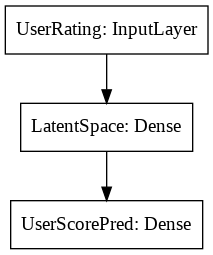

In [ ]:
plot_model(AutoRec, to_file='AutoRec.png')

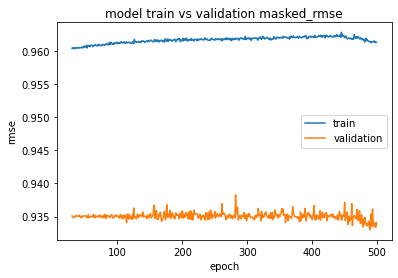

In [ ]:
show_rmse(hist_Autorec, 30)

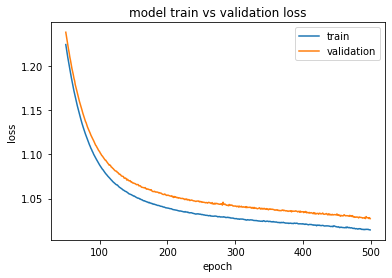

In [ ]:
show_error(hist_Autorec, 50)

In [ ]:
print(users_items_matrix_train_average.dtype)
users_items_matrix_test= users_items_matrix_test.astype(np.float64)
print(users_items_matrix_test.dtype)
test_result = AutoRec.evaluate(users_items_matrix_train_average, users_items_matrix_test)

float64
float64
189/189 [==============================] - 1s 3ms/step - loss: 1.0351 - masked_rmse_clip: 0.9422


In [ ]:
predict_autorec = AutoRec.predict(users_items_matrix_train_three)

In [ ]:
loss = K.eval(masked_rmse_clip( 
    K.constant((users_items_matrix_train_three)), 
    K.constant(predict_autorec)))
np.mean(loss)

0.94067013

I tried a few different default ratings but with the same activation functions and parameters and the default rating of 0 performed the best.


In [ ]:
# users_items_matrix_train_average = users_items_matrix_train_average.astype(np.int64)# tf.cast(users_items_matrix_train_average, tf.float32)
print(users_items_matrix_train_average.dtype)
print(users_items_matrix_train_zero.dtype)
users_items_matrix_train_zero=users_items_matrix_train_zero.astype(np.float64)
users_items_matrix_validate= users_items_matrix_validate.astype(np.float64)
print(users_items_matrix_validate.dtype)
hist_Autorec = AutoRec.fit(users_items_matrix_train_average, users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=(users_items_matrix_train_average, users_items_matrix_validate))

float64
float64
float64
Epoch 1/500
24/24 - 1s - loss: 1.0161 - masked_rmse_clip: 0.9624 - val_loss: 1.0341 - val_masked_rmse_clip: 0.9376
Epoch 2/500
24/24 - 0s - loss: 1.0190 - masked_rmse_clip: 0.9621 - val_loss: 1.0323 - val_masked_rmse_clip: 0.9347
Epoch 3/500
24/24 - 0s - loss: 1.0197 - masked_rmse_clip: 0.9620 - val_loss: 1.0321 - val_masked_rmse_clip: 0.9342
Epoch 4/500
24/24 - 0s - loss: 1.0185 - masked_rmse_clip: 0.9616 - val_loss: 1.0311 - val_masked_rmse_clip: 0.9334
Epoch 5/500
24/24 - 0s - loss: 1.0182 - masked_rmse_clip: 0.9613 - val_loss: 1.0322 - val_masked_rmse_clip: 0.9348
Epoch 6/500
24/24 - 0s - loss: 1.0181 - masked_rmse_clip: 0.9613 - val_loss: 1.0312 - val_masked_rmse_clip: 0.9340
Epoch 7/500
24/24 - 0s - loss: 1.0173 - masked_rmse_clip: 0.9612 - val_loss: 1.0298 - val_masked_rmse_clip: 0.9341
Epoch 8/500
24/24 - 0s - loss: 1.0170 - masked_rmse_clip: 0.9611 - val_loss: 1.0306 - val_masked_rmse_clip: 0.9334
Epoch 9/500
24/24 - 0s - loss: 1.0169 - masked_rmse_clip

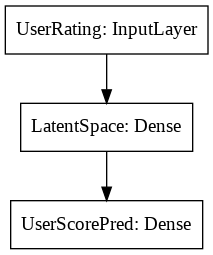

In [ ]:
plot_model(AutoRec, to_file='AutoRec.png')

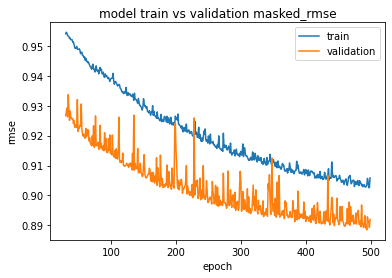

In [ ]:
show_rmse(hist_Autorec, 30)

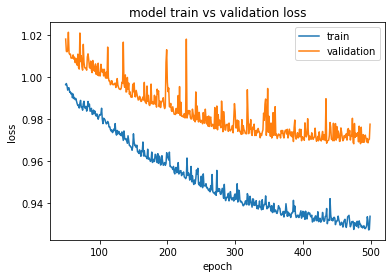

In [ ]:
show_error(hist_Autorec, 50)

In [ ]:
print(users_items_matrix_train_average.dtype)
users_items_matrix_test= users_items_matrix_test.astype(np.float64)
print(users_items_matrix_test.dtype)
test_result = AutoRec.evaluate(users_items_matrix_train_average, users_items_matrix_test)

float64
float64
189/189 [==============================] - 1s 3ms/step - loss: 0.9846 - masked_rmse_clip: 0.8993


In [ ]:
predict_autorec = AutoRec.predict(users_items_matrix_train_zero)

In [ ]:
loss = K.eval(masked_rmse_clip( 
    K.constant((users_items_matrix_train_zero)), 
    K.constant(predict_autorec)))
np.mean(loss)

2.1728806

Since the *Training deep autoencoders for collaborative filtering* paper found that activations with non-zero negative part and unbounded positive part perform better for deep autoencoders, I tried ELU on AutoRec.

The model will have the same parameters and a default rating of 0 but with an activation function of ELU.

In [ ]:
# Build model

AutoRec = AutoRec(users_items_matrix_train_zero, 0.0005, 'elu', 'elu')

AutoRec.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
LatentSpace (Dense)          (None, 500)               1976500   
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1979952   
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# users_items_matrix_train_average = users_items_matrix_train_average.astype(np.int64)# tf.cast(users_items_matrix_train_average, tf.float32)
print(users_items_matrix_train_average.dtype)
print(users_items_matrix_train_zero.dtype)
users_items_matrix_train_zero=users_items_matrix_train_zero.astype(np.float64)
users_items_matrix_validate= users_items_matrix_validate.astype(np.float64)
print(users_items_matrix_validate.dtype)
hist_Autorec = AutoRec.fit(users_items_matrix_train_average, users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=(users_items_matrix_train_average, users_items_matrix_validate))

float64
float64
float64
Epoch 1/500
24/24 - 1s - loss: 7.1919 - masked_rmse_clip: 1.8650 - val_loss: 3.4559 - val_masked_rmse_clip: 1.2962
Epoch 2/500
24/24 - 0s - loss: 2.4854 - masked_rmse_clip: 1.1370 - val_loss: 2.0001 - val_masked_rmse_clip: 0.9821
Epoch 3/500
24/24 - 0s - loss: 1.8083 - masked_rmse_clip: 0.9578 - val_loss: 1.7731 - val_masked_rmse_clip: 0.9169
Epoch 4/500
24/24 - 0s - loss: 1.7166 - masked_rmse_clip: 0.9291 - val_loss: 1.7370 - val_masked_rmse_clip: 0.9126
Epoch 5/500
24/24 - 0s - loss: 1.6804 - masked_rmse_clip: 0.9252 - val_loss: 1.7107 - val_masked_rmse_clip: 0.9102
Epoch 6/500
24/24 - 0s - loss: 1.6560 - masked_rmse_clip: 0.9233 - val_loss: 1.6927 - val_masked_rmse_clip: 0.9102
Epoch 7/500
24/24 - 0s - loss: 1.6388 - masked_rmse_clip: 0.9232 - val_loss: 1.6746 - val_masked_rmse_clip: 0.9100
Epoch 8/500
24/24 - 0s - loss: 1.6248 - masked_rmse_clip: 0.9240 - val_loss: 1.6616 - val_masked_rmse_clip: 0.9101
Epoch 9/500
24/24 - 0s - loss: 1.6101 - masked_rmse_clip

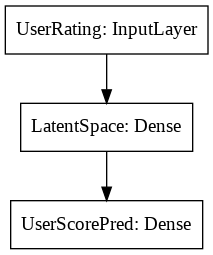

In [ ]:
plot_model(AutoRec, to_file='AutoRec.png')

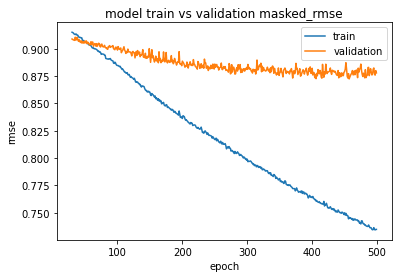

In [ ]:
show_rmse(hist_Autorec, 30)

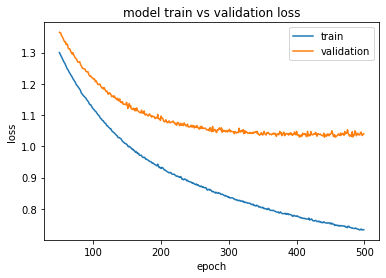

In [ ]:
show_error(hist_Autorec, 50)

In [ ]:
print(users_items_matrix_train_average.dtype)
users_items_matrix_test= users_items_matrix_test.astype(np.float64)
print(users_items_matrix_test.dtype)
test_result = AutoRec.evaluate(users_items_matrix_train_average, users_items_matrix_test)

float64
float64
189/189 [==============================] - 0s 2ms/step - loss: 1.0392 - masked_rmse_clip: 0.8801


In [ ]:
predict_autorec = AutoRec.predict(users_items_matrix_train_zero)

In [ ]:
loss = K.eval(masked_rmse_clip( 
    K.constant((users_items_matrix_train_zero)), 
    K.constant(predict_autorec)))
np.mean(loss)

2.4744966

<a name="DECF"></a>
###Training deep autoencoders for collaborative filtering [5] [6]

This paper essentially deepens the autoencoder by introducing activation functions with non-zero negative part and unbounded positive part. Also, it uses dropout layers after the latent layer to avoid overfitting.

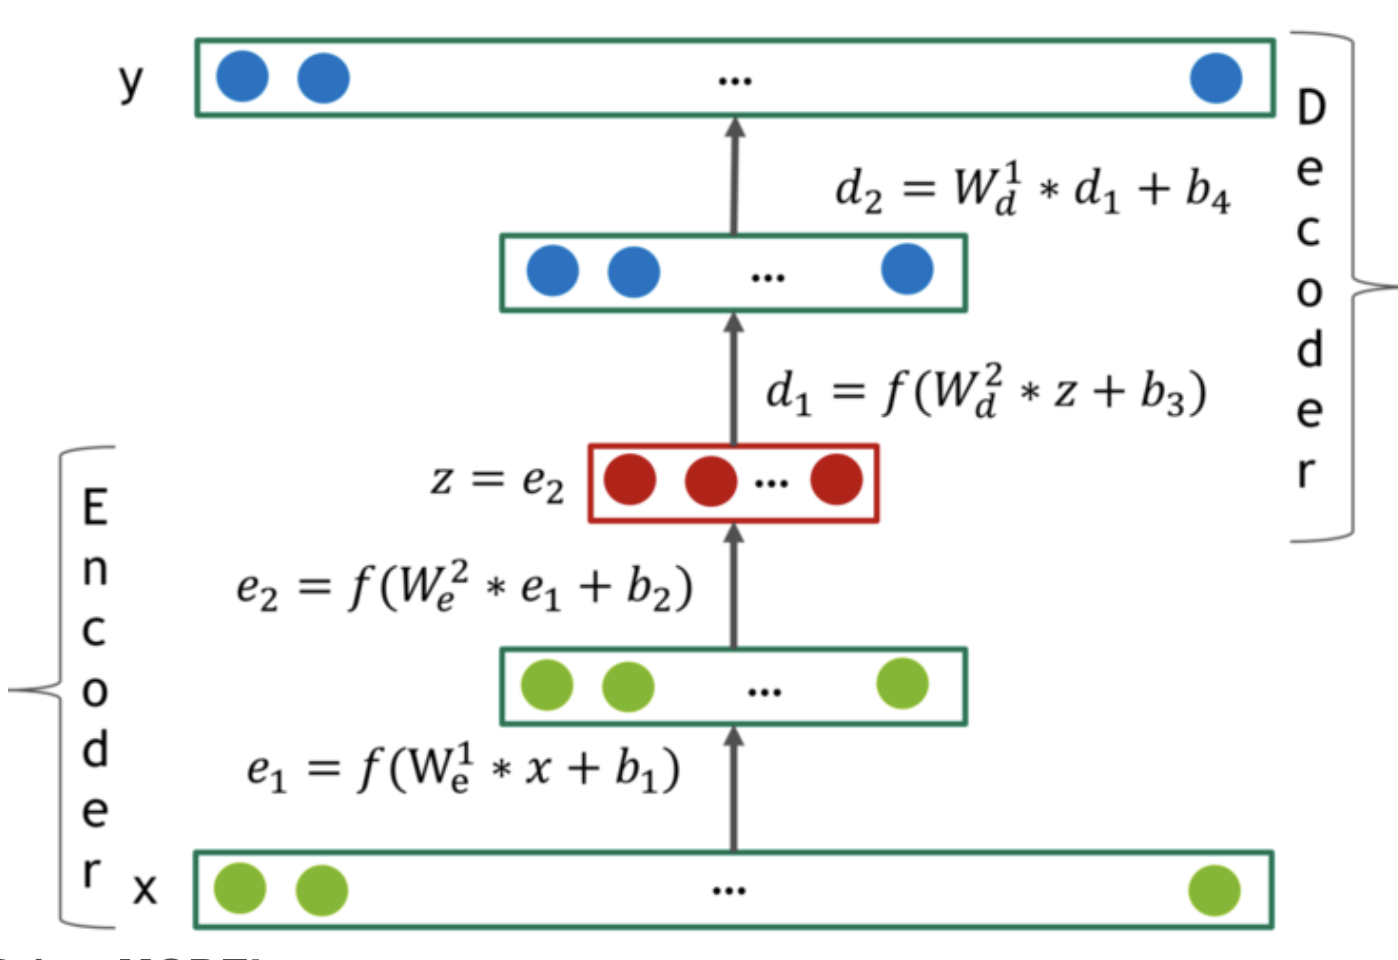
Figure 2 depicts a typical 4-layer autoencoder network. The encoder has 2 layers e1, and e2, while the decoder has 2 layers d1 and d2. They are fused together on the representation z. The layers are represented as f(W * x + b), where f is some non-linear activation function. If the range of the activation function is smaller than that of the data, the last layer of the decoder should be kept linear. 

In [ ]:
def Deep_AE_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, side_infor_size=0):
    '''
    Build Deep AE for CF
        INPUT: 
            X: #_user X #_item matrix
            layers: List, each element is the number of neuron for a layer
            reg: L2 regularization parameter
            activation: activation function for all dense layer except the last
            last_activation: activation function for the last dense layer
            dropout: dropout rate
            regularizer_encode: regularizer for encoder
            regularizer_decode: regularizer for decoder
            side_infor_size: size of the one hot encoding side information
        OUTPUT:
            Keras model
    '''

    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    
    # Encoder
    # -----------------------------
    k = int(len(layers)/2)
    i = 0
    for l in layers[:k]:
      x = Dense(l, activation=activation,
                      name='EncLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_encode))(x)
      i = i+1
      
      
    # Latent Space
    # -----------------------------
    x = Dense(layers[k], activation=activation, 
                                name='LatentSpace', kernel_regularizer=regularizers.l2(regularizer_encode))(x)
    
    # Dropout
    x = Dropout(rate = dropout)(x)
    
    # Decoder
    # -----------------------------
    for l in layers[k+1:]:
      i = i-1
      x = Dense(l, activation=activation, 
                      name='DecLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_decode))(x)
      
    # Output

    output_layer = Dense(X.shape[1]-side_infor_size, activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model

We tested different layers and activation function and found that the model that has layers of [256, 512, 256] with a added dropout layer of 0.8 and an activation function of SELU. L2 regularization was also added to the encoder and decoder gave the best results.

In [ ]:
layers = [256, 512, 256]
#layers = [512, 256, 128, 256, 512]
#layers = [512, 256, 512]
#layers = [128, 256, 512, 256, 128]
#layers = [512, 512, 512]
dropout = 0.8
# activation = 'sigmoid'
# last_activation = 'linear'
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [ ]:
# Build model
Deep_AE = Deep_AE_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               1011968   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1015664   
Total params: 2,290,544
Trainable params: 2,290,544
Non-trainable params: 0
_________________________________________________

In [ ]:
# users_items_matrix_train_zero= users_items_matrix_train_zero.astype(np.float32)
# users_items_matrix_validate= users_items_matrix_validate.astype(np.float32)
# print(users_items_matrix_train_zero.dtype)
# print(users_items_matrix_validate.dtype)
hist_Deep_AE = Deep_AE.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  validation_data=(users_items_matrix_train_zero, users_items_matrix_validate), verbose=2)

Epoch 1/500
24/24 - 1s - loss: 16.2651 - masked_rmse_clip: 2.8566 - val_loss: 13.9201 - val_masked_rmse_clip: 2.8058
Epoch 2/500
24/24 - 0s - loss: 10.9935 - masked_rmse_clip: 2.4641 - val_loss: 6.6522 - val_masked_rmse_clip: 1.9452
Epoch 3/500
24/24 - 0s - loss: 6.1325 - masked_rmse_clip: 1.8196 - val_loss: 3.8788 - val_masked_rmse_clip: 1.3886
Epoch 4/500
24/24 - 0s - loss: 4.2139 - masked_rmse_clip: 1.4799 - val_loss: 3.0738 - val_masked_rmse_clip: 1.1539
Epoch 5/500
24/24 - 0s - loss: 3.6688 - masked_rmse_clip: 1.3524 - val_loss: 2.8430 - val_masked_rmse_clip: 1.0825
Epoch 6/500
24/24 - 0s - loss: 3.4567 - masked_rmse_clip: 1.3071 - val_loss: 2.7252 - val_masked_rmse_clip: 1.0471
Epoch 7/500
24/24 - 0s - loss: 3.3267 - masked_rmse_clip: 1.2802 - val_loss: 2.6469 - val_masked_rmse_clip: 1.0262
Epoch 8/500
24/24 - 0s - loss: 3.2101 - masked_rmse_clip: 1.2509 - val_loss: 2.5873 - val_masked_rmse_clip: 1.0117
Epoch 9/500
24/24 - 0s - loss: 3.1370 - masked_rmse_clip: 1.2386 - val_loss: 

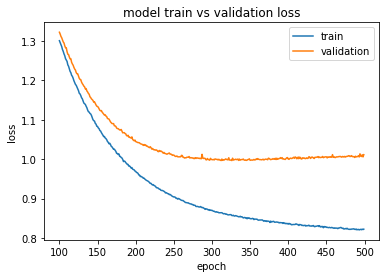

In [ ]:
show_error(hist_Deep_AE, 100)

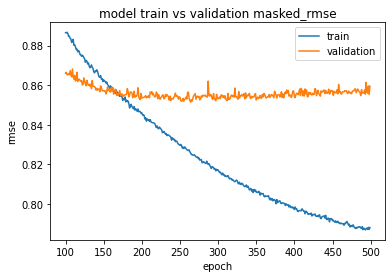

In [ ]:
show_rmse(hist_Deep_AE, 100)

In [ ]:
predict_deep = Deep_AE.predict(users_items_matrix_train_zero)

In [ ]:

test_result_deep = Deep_AE.evaluate(users_items_matrix_train_zero, users_items_matrix_test)

189/189 [==============================] - 0s 2ms/step - loss: 1.0045 - masked_rmse_clip: 0.8600


In [ ]:
for layer in Deep_AE.layers: 
  print(layer.get_config())

{'batch_input_shape': (None, 3952), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'UserRating'}
{'name': 'EncLayer0', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'selu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L2', 'config': {'l2': 0.0010000000474974513}}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'LatentSpace', 'trainable': True, 'dtype': 'float32', 'units': 512, 'activation': 'selu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L2', 'config': {'l2': 0.0010000000474974513}}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constrain

In [ ]:
first_layer_weights = Deep_AE.layers[1].get_weights()[0]

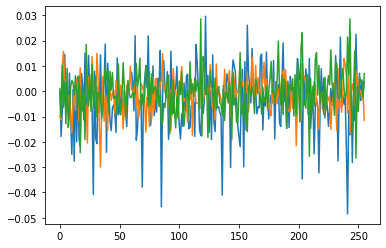

In [ ]:
first_layer_weights = Deep_AE.layers[1].get_weights()[0]
plt.plot(np.arange(0, 256, 1), first_layer_weights[0])
plt.plot(np.arange(0, 256, 1), first_layer_weights[1])
plt.plot(np.arange(0, 256, 1), first_layer_weights[2])
plt.show()

<a name="CDE"></a>
# Collaborative denoising auto-encoders for top-n recommender systems [4] [9]

In *Collaborative denoising auto-encoders for top-n recommender systems*, common corruption choices are the additive Gaussian noise and multplicative dropout noise. So in this section we will test it out.

<a name="GAR"></a>
###Adding Gaussian to Autorec



We add a noise factor of 0.4 to the matrix and then run it through the autoencoder that performed the best.

In [ ]:
## Adding Gaussin noise to input
# users_items_matrix_train_average = dataPreprocessor(train_df, num_users, num_movies, average=True)
# users_items_matrix_train_zero = dataPreprocessor(train_df, num_users, num_movies, 0)
noise_factor = 0.4
users_items_matrix_train_average_noisy = users_items_matrix_train_average + noise_factor * np.random.normal(size=users_items_matrix_train_zero.shape) 
users_items_matrix_train_zero_noisy = users_items_matrix_train_zero + noise_factor * np.random.normal(size=users_items_matrix_train_zero.shape)

In [ ]:
users_items_matrix_train_average_noisy

array([[4.67134734, 3.55808133, 4.18010952, ..., 3.92636868, 4.21864178,
        4.1999157 ],
       [3.7890671 , 3.5690353 , 3.97592981, ..., 3.51617208, 4.18303348,
        3.68390625],
       [4.38831549, 3.55137662, 4.95368086, ..., 3.7442052 , 3.61915861,
        3.77769068],
       ...,
       [4.0375576 , 3.43196456, 3.93520738, ..., 3.12725243, 3.80895925,
        3.75551562],
       [4.32907922, 3.1460432 , 4.38220702, ..., 3.47513086, 4.03288251,
        3.91775397],
       [4.05749735, 3.25625859, 2.89276136, ..., 3.39608614, 3.45840544,
        3.41766312]])

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#run AutoRec again
AutoRec = AutoRec(users_items_matrix_train_average_noisy, 0.001, 'elu', 'elu')

AutoRec.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec.summary()

hist_Autorec = AutoRec.fit(x=users_items_matrix_train_average_noisy, y=users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_average_noisy, users_items_matrix_validate])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
LatentSpace (Dense)          (None, 500)               1976500   
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1979952   
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________
Train on 6040 samples, validate on 6040 samples
Epoch 1/500
6040/6040 - 1s - loss: 8.3507 - masked_rmse_clip: 1.8934 - val_loss: 4.6042 - val_masked_rmse_clip: 1.3389
Epoch 2/500
6040/6040 - 1s - loss: 3.5612 - masked_rmse_clip: 1.1831 - val_loss: 2.9694 - val_masked_rmse_clip: 1.0134
Epoch 3/500
6040/6040 - 1s - loss: 2.6836 - masked_rmse_clip: 0.9889 - val_loss: 2.5880 - val

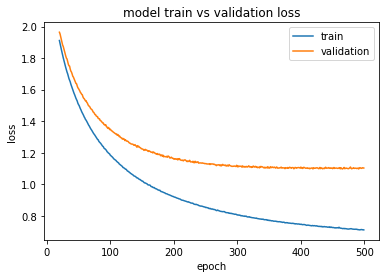

In [ ]:
show_error(hist_Autorec, 20)

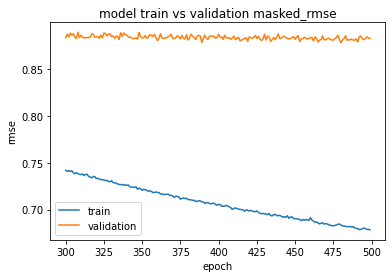

In [ ]:
show_rmse(hist_Autorec, 300)

In [ ]:
test_result_deep = AutoRec.evaluate(users_items_matrix_train_average_noisy, users_items_matrix_test)
print(test_result_deep)

[1.1009642751011628, 0.884875]


<a name="DAE"></a>
###Adding Gaussian to Deep Autoencoder

Next, we add denoising to Deep Autoencoder with layers of [256, 512, 256] and a default rating of 0 from the deep autoencoder that we performed wih an activation of SELU and a L2 regularizer of 0.001 for the encoder and decoder. 

In [ ]:
layers = [256, 512, 256]
dropout = 0.8

activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [ ]:
# Build model
Deep_AE_denoise = Deep_AE_model(users_items_matrix_train_zero_noisy, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE_denoise.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_denoise.summary()


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               1011968   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1015664   
Total params: 2,290,544
Trainable params: 2,290,544
Non-trainable params: 0
_________________________________________________

In [ ]:
hist_Deep_AE_denoise = Deep_AE_denoise.fit(x=users_items_matrix_train_zero_noisy, y=users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero_noisy, users_items_matrix_validate], verbose=2)

Train on 6040 samples, validate on 6040 samples
Epoch 1/500
6040/6040 - 1s - loss: 16.5785 - masked_rmse_clip: 2.8614 - val_loss: 15.1758 - val_masked_rmse_clip: 2.8524
Epoch 2/500
6040/6040 - 1s - loss: 12.1439 - masked_rmse_clip: 2.5723 - val_loss: 7.8090 - val_masked_rmse_clip: 2.1316
Epoch 3/500
6040/6040 - 1s - loss: 7.1211 - masked_rmse_clip: 1.9355 - val_loss: 4.6012 - val_masked_rmse_clip: 1.5513
Epoch 4/500
6040/6040 - 1s - loss: 4.8298 - masked_rmse_clip: 1.5902 - val_loss: 3.4414 - val_masked_rmse_clip: 1.2497
Epoch 5/500
6040/6040 - 1s - loss: 4.0409 - masked_rmse_clip: 1.4300 - val_loss: 3.0641 - val_masked_rmse_clip: 1.1383
Epoch 6/500
6040/6040 - 1s - loss: 3.7595 - masked_rmse_clip: 1.3633 - val_loss: 2.9093 - val_masked_rmse_clip: 1.0919
Epoch 7/500
6040/6040 - 1s - loss: 3.6099 - masked_rmse_clip: 1.3332 - val_loss: 2.8106 - val_masked_rmse_clip: 1.0627
Epoch 8/500
6040/6040 - 1s - loss: 3.5187 - masked_rmse_clip: 1.3136 - val_loss: 2.7550 - val_masked_rmse_clip: 1.04

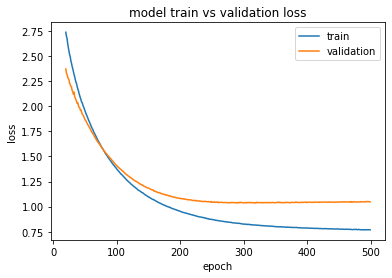

In [ ]:
show_error(hist_Deep_AE_denoise, 20)

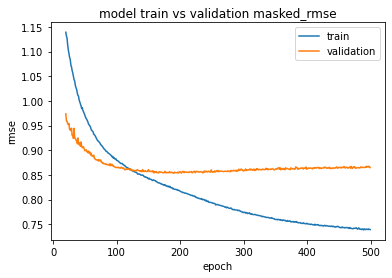

In [ ]:
show_rmse(hist_Deep_AE_denoise, 20)

In [ ]:
test_result_deep = Deep_AE_denoise.evaluate(users_items_matrix_train_zero_noisy, users_items_matrix_test)
print(test_result_deep)

[1.0407811433274226, 0.86715734]


In [ ]:
predict_deep = Deep_AE_denoise.predict(users_items_matrix_train_zero_noisy)
loss = K.eval(masked_rmse_clip( 
    K.constant((users_items_matrix_train_zero)), 
    K.constant(predict_deep)))
np.mean(loss)

0.6994175

<a name="DN"></a>
###Adding Dropout Noise

In *Collaborative denoising auto-encoders for top-n recommender systems*, it masked out non-zero elements randomly in each batch and use the masked input. But instead, I added a dropout layer between input and first dense layer. This dropout will mask out all elements randomly with a dropout rate.

In [ ]:
def Deep_AE_DropNoise_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, noise):
    '''
    Build Deep AE for CF
    '''

    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    
    # Dropout Noise
    x = Dropout(rate = noise)(x)
    
    # Encoder
    # -----------------------------
    k = int(len(layers)/2)
    i = 0
    for l in layers[:k]:
      x = Dense(l, activation=activation,
                      name='EncLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_encode))(x)
      i = i+1
      
      
    # Latent Space
    # -----------------------------
    x = Dense(layers[k], activation=activation, 
                                name='LatentSpace', kernel_regularizer=regularizers.l2(regularizer_encode))(x)
    
    # Dropout
    x = Dropout(rate = dropout)(x)
    
    # Decoder
    # -----------------------------
    for l in layers[k+1:]:
      i = i-1
      x = Dense(l, activation=activation, 
                      name='DecLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_decode))(x)
    # Output

    output_layer = Dense(X.shape[1], activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model

The architecture of the model is essentially the same as adding Gaussian to the Deep Encoder except there is an added Dropout Noise of 0.1. 

In [ ]:
layers = [256, 512, 256]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001
dropN = 0.1
# Build model
Deep_AE_denoise_dropN = Deep_AE_DropNoise_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, dropN)
Deep_AE_denoise_dropN.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_denoise_dropN.summary()
hist_Deep_AE_denoise_dropN = Deep_AE_denoise_dropN.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate], verbose=2)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3952)              0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               1011968   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1015

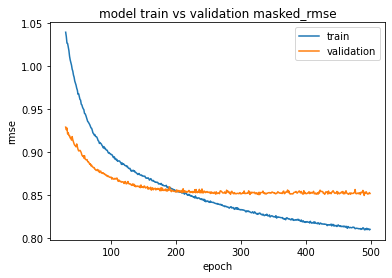

In [ ]:
show_rmse(hist_Deep_AE_denoise_dropN, 30)

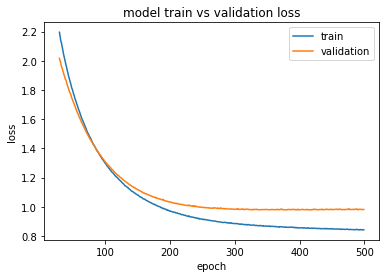

In [ ]:
show_error(hist_Deep_AE_denoise_dropN, 30)

In [ ]:
test_result_deep = Deep_AE_denoise_dropN.evaluate(users_items_matrix_train_zero, users_items_matrix_test)
print(test_result_deep)

[0.9814045081864919, 0.85533935]


<a name="ResultsDiscussions"></a>
# Results and Discussions

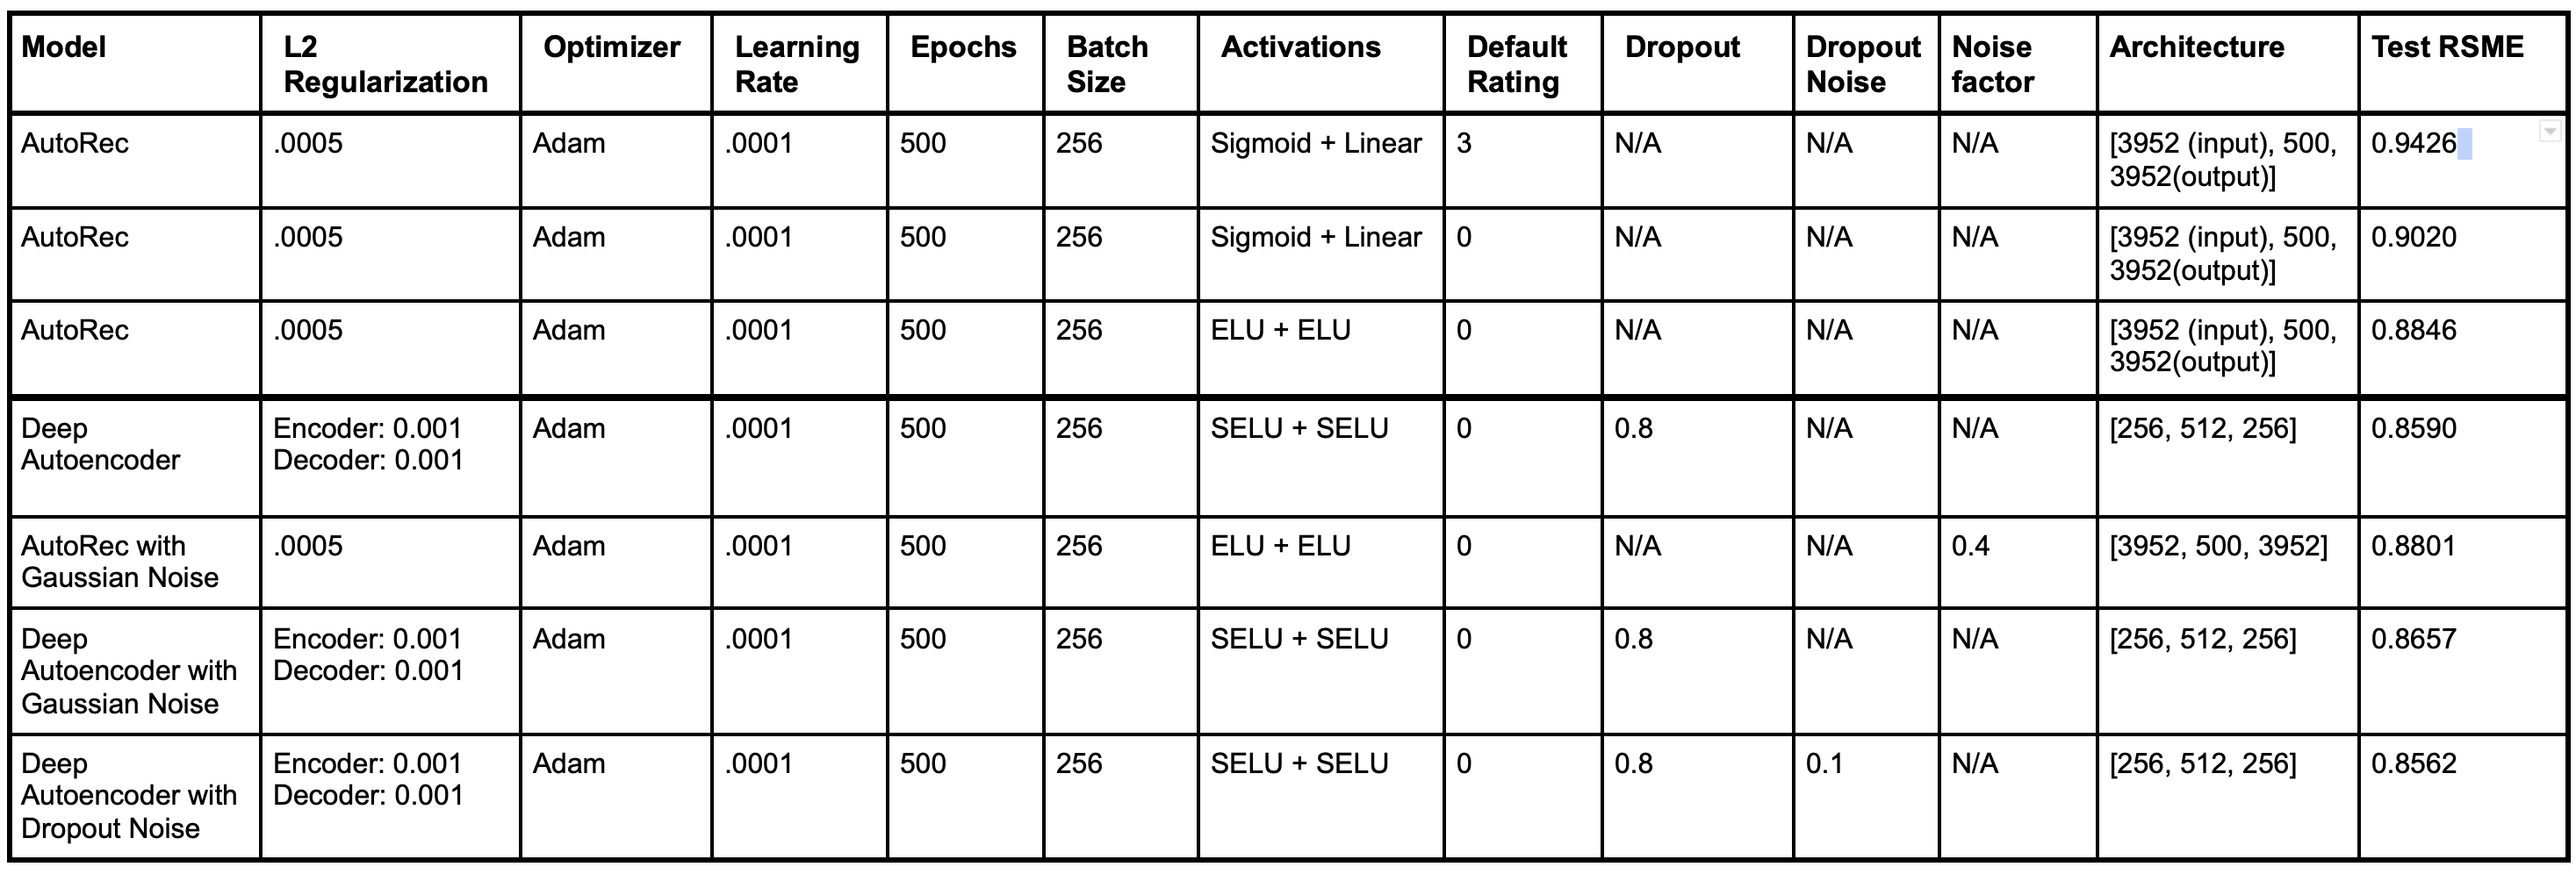

Table 1. Specification, Hyperparameters, and Test RSME of all models implemented. 

On observation of the different models created, it was apparent that a deep autoencoder with dropout noise performed better as compared to the other models. Sigmoid and linear activation functions affected the performance of AutoRec considerably. In *Training deep autoencoders for collaborative filtering*, activations with non-zero negative parts and unbounded positive parts boosted the performance. Consequently, I implemented the ELU activation function on the AutoRec model and this gave a slight improvement from the baseline by 4%. This can be seen through the low Masked Root Mean Squared Error (RMSE) in rating prediction. Additionally, using the default rating of 0 as compared to 3 allowed slower convergence and less likely to overfit. In the AutoRec model, a default rating of 3 gave a test RSME of 0.9426 as compared to 0.9020. Moreover, an increase in the number of hidden neurons or the number of layers also improved the model performance. The potential reason for this can be that increasing the dimensionality of the hidden layer allows AutoRec to focus on the input features. As a result, creating a deep autoencoder by adding more layers lead to a slight improvement. In the deep autoencoder, dropout layers are used after the latent layer to avoid overfitting. I observed that a large dropout rate after the latent layers allowed the model to learn robust representations. From C*ollaborative denoising auto-encoders for top-n recommender systems*, noise also had a factor in the performance of the model. Thus, I added Gaussian noise to the AutoRec model and to the deep autoencoder. Gaussian noise did not improve the model for the deep autoencoder considering that the default rating had a significant impact on the performance and adding noise may have changed the default rating. Likewise, I experimented with Dropout Noise and added the layer before the encoding in the deep autoencoder. This will ensure that the unobserved inputs are masked out and only observed ratings contribute to the model learning process. This model resulted in a significant improvement with an RSME of 0.8532 as compared to AutoRec and all the models. 

Deep learning revolutionized many areas of machine learning and allow us to build state-of-the-art recommender systems that improve our quality of life. In this project, I implemented a few models to have a better understanding of the features that make a good recommender system. I implemented AutoRec which is one of the earliest models that consider the collaborative filtering problem from an autoencoder perspective. Autoencoders were implemented as it has a better understanding of the user demands and item features, thus leading to higher recommendation accuracy than traditional models. I implemented the user-based AutoRec as opposed to the item-based AutoRec because in real-world recommender systems, there are usually more users than items. Further, when facing scaling problems in personalized recommender systems, it is more acceptable to sample items and not users. I discovered that deep autoencoders improved the performance of the model however adding Gaussian noise degraded the performance. However, the addition of a dropout Noise layer before the encoder gave the highest performance. In future work, we can be fully implementing dense re-feeding with dropout noise. With cross-validation and better hyperparameter tuning, we can produce more accurate results. 


<a name="References"></a>
# References

[1]  G. (2003, February). MovieLens 1M Dataset. 
Retrieved from http://www.grouplens.org/datasets/movielens/1m/

[2]  Gtshs2. (2018, June 25). Gtshs2/Autorec. Retrieved April 14, 2021, from https://github.com/gtshs2/Autorec

[3] HarilalOP. (2019, August 29). HarilalOP/movielens-data-exploration. Retrieved April 1, 2021, from https://github.com/HarilalOP/movielens-data-exploration

[4] Henry0312. (2016, May 27). Henry0312/CDAE. Retrieved April 20, 2021, from https://github.com/henry0312/CDAE

[5] Kuchaiev, O., & Ginsburg, B. (2017). Training deep autoencoders for collaborative filtering. arXiv preprint arXiv:1708.01715.

[6] Nvidia. (2019, January 7). NVIDIA/DeepRecommender. Retrieved April 18, 2021, from https://github.com/NVIDIA/DeepRecommender

[7] RaptorMai. (2019, December 30). RaptorMai/Deep-AutoEncoder-Recommendation. Retrieved May 4, 2021, from https://github.com/RaptorMai/Deep-AutoEncoder-Recommendation

[8] Sedhain, S., Menon, A. K., Sanner, S., & Xie, L. (2015, May). Autorec: Autoencoders meet collaborative filtering. In Proceedings of the 24th international conference on World Wide Web (pp. 111-112).

[9] Wu, Y., DuBois, C., Zheng, A. X., & Ester, M. (2016, February). Collaborative denoising auto-encoders for top-n recommender systems. In Proceedings of the ninth ACM international conference on web search and data mining (pp. 153-162).
